In [1]:
!pip install openmeteo-requests
!pip install requests-cache
!pip install retry-requests
!pip install codecarbon

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import os
import matplotlib.pyplot as plt

import openmeteo_requests
import requests_cache
import requests
from retry_requests import retry

import codecarbon
from codecarbon import track_emissions, EmissionsTracker

import glob
import sklearn
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xarray as xr
from datetime import datetime

#filePath=os.path.dirname(__file__)
#PATH=filePath+PATH
PATH = '/gws/nopw/j04/ai4netzero/Craig/'
SCALE_FACTOR = 60 * 60 * 24 * 1000

2025-03-07 09:29:42.352245: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
CROP = 'Miscanthus'

if CROP == 'Winter Wheat':
    CROP_ABV = 'WW'
elif CROP == 'Spring Wheat':
    CROP_ABV = 'SW'
elif CROP == 'Maize':
    CROP_ABV = 'MZ'
elif CROP == 'Miscanthus':
    CROP_ABV = 'MC'

In [4]:
import shutil
## Current notebook name
#current_notebook = f'SURROGATE_TRAINING_WW.ipynb'
## Desired filepath
#destination_path = PATH + current_notebook
## Save the notebook to the desired filepath
#shutil.copyfile(current_notebook, destination_path)

In [5]:
def LoadVariables():

  RCP = [2.6, 4.5, 6.0, 8.5]

  JULES_CROP_DICT = {
    'Winter Wheat': [0, 266],
    'Spring Wheat': [1, 267],
    'Maize': [2, 268],
    'Miscanthus': [3, 269]
  }

  column_features = [
                              'precip',
                              'pstar',
                              'q1p5m_gb',
                              'rad_net',
                              'smcl',
                              'tstar_gb',
                              'sw_down',
                              'cropsowdate',
                              'croptype'
                              ]

  column_targets = [
                        #'resp_p_gb',
                        #'resp_s_gb',
                        'ter',
                        'gpp_gb',
                        'cropyield'
                      ]

  return RCP, JULES_CROP_DICT, column_features, column_targets

In [6]:
class GNNLayer(layers.Layer):
    def __init__(self, units, **kwargs): # Add **kwargs to accept additional arguments like 'name'
        super(GNNLayer, self).__init__(**kwargs)  # Pass any arguments to the parent class
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="zeros", trainable=True
        )

    def call(self, inputs):
        adj_matrix = tf.linalg.matmul(inputs, inputs, transpose_a=True)
        adj_matrix = adj_matrix / tf.norm(adj_matrix)
        adj_inputs = tf.matmul(inputs, adj_matrix)
        combined_inputs = tf.multiply(inputs, tf.constant(0.9)) + tf.multiply(adj_inputs, tf.constant(0.1))
        return tf.matmul(combined_inputs, self.w) + self.b

    def get_config(self): # Define get_config to serialize the layer
        config = super(GNNLayer, self).get_config()
        config.update({"units": self.units})
        return config

    @classmethod
    def from_config(cls, config): # Define from_config to deserialize the layer
        return cls(**config)

def custom_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
    loss = mse(y_true, y_pred)
    data_loss = tf.scalar_mul(loss, tf.constant(0.5))
    pi_loss1 = tf.reduce_mean(tf.maximum(0.0, -y_pred[:, 0]))  # Penalize negative ter
    pi_loss1 = tf.scalar_mul(loss, tf.constant(0.25))
    pi_loss2 = tf.reduce_mean(tf.maximum(0.0, -y_pred[:, 1]))  # Penalize negative gpp
    pi_loss2 = tf.scalar_mul(loss, tf.constant(0.25))
    return data_loss + pi_loss1 + pi_loss2

In [7]:
def build_JULESgnn_model(input_shape):

    N_LAYERS = 4
    N_NEURONS = 64

    inputs = keras.Input(shape=(input_shape,))
    x = GNNLayer(N_NEURONS)(inputs)
    x = keras.layers.Activation("relu", name="activation_1")(x)

    for i in range(N_LAYERS):
      N_NEURONS = N_NEURONS // 2
      x = GNNLayer(N_NEURONS)(x)
      x = keras.layers.Activation("relu", name=f"activation_{i+2}")(x)

    outputs = keras.layers.Dense(len(column_targets))(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss=custom_loss, metrics=['mse'])
    return model

In [8]:
def LoadCropData(CROP, CROPSOWDATE):

  _, JULES_CROP_DICT, column_features, column_targets = LoadVariables()

  CROP_CODE = JULES_CROP_DICT[CROP][1]
  CROP_TYPE = JULES_CROP_DICT[CROP][0]
  JASMIN_PATH = f'/gws/nopw/j04/ai4netzero/data/jules-crop/outputs/chess-met_expts/fluxnet_site_runs/u-dn{CROP_CODE}/merged_output/u-dn{CROP_CODE}_jules_crop.daily.2006-2019.nc'

  ds = xr.open_dataset(JASMIN_PATH)
  df_jules = ds.to_dataframe()
  df_jules1 = df_jules.reset_index(level=list(np.arange(df_jules.index.nlevels)))
  df_jules1.index = pd.to_datetime(df_jules1.index)
  df_jules1['year'] = df_jules1.index.year
  df_jules1 = df_jules1[df_jules1.bnds == 0]
  df_jules1 = df_jules1[df_jules1.soil == 0]
  df_jules1['ter'] = df_jules1['resp_p_gb'] + df_jules1['resp_s_gb']
  df_jules1['croptype'] = CROP_TYPE * np.ones(len(df_jules1))
  df_jules1['cropsowdate'] = CROPSOWDATE * np.ones(len(df_jules1))
  df_jules1['cropyield'] = df_jules1.groupby(['year'])['cropyield'].transform('max')

  return df_jules1[column_features + column_targets]

In [9]:
CROP

'Miscanthus'

In [10]:
if CROP == 'Winter Wheat':
    JULES_DATA = LoadCropData(CROP = 'Winter Wheat', CROPSOWDATE = 273)
elif CROP == 'Spring Wheat':
    JULES_DATA = LoadCropData(CROP = 'Spring Wheat', CROPSOWDATE = 128)
elif CROP == 'Maize':
    JULES_DATA = LoadCropData(CROP = 'Maize', CROPSOWDATE = 130)
elif CROP == 'Miscanthus':
    JULES_DATA = LoadCropData(CROP = 'Miscanthus', CROPSOWDATE = 97)

In [11]:
JULES_DATA

,precip,pstar,q1p5m_gb,rad_net,smcl,tstar_gb,sw_down,cropsowdate,croptype,ter,gpp_gb,cropyield
1970-01-01 00:00:00.000000000,0.000024,101457.773438,0.005048,-6.253504,17.079767,277.944733,18.958282,97.0,3.0,2.684280e-08,9.138128e-09,0.003777
1970-01-01 00:00:00.000000004,0.000027,101399.195312,0.005041,-6.674082,43.137157,277.991394,18.910673,97.0,3.0,3.996622e-08,8.923202e-09,0.003777
1970-01-01 00:00:00.000000008,0.000000,101415.210938,0.005054,-6.970085,43.649960,277.998932,19.973644,97.0,3.0,3.974221e-08,9.784997e-09,0.003777
1970-01-01 00:00:00.000000012,0.000010,101468.210938,0.005031,-6.427001,32.762424,277.903961,18.483866,97.0,3.0,4.768422e-08,9.102433e-09,0.003777
1970-01-01 00:00:00.000000016,0.000009,101464.945312,0.005028,-6.358905,32.807678,277.883759,18.432646,97.0,3.0,4.753823e-08,9.026857e-09,0.003777
...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000327180,0.000000,101418.945312,0.005587,-11.155608,31.638174,278.564362,23.342186,97.0,3.0,5.533843e-08,1.195986e-08,0.003777
1970-01-01 00:00:00.000327184,0.000000,101415.507812,0.005577,-11.180127,31.720938,278.537933,23.692108,97.0,3.0,5.546961e-08,1.229733e-08,0.003777
1970-01-01 00:00:00.000327188,0.000000,101389.789062,0.005574,-9.962638,32.007076,278.523163,22.595297,97.0,3.0,5.615466e-08,1.304295e-08,0.003777
1970-01-01 00:00:00.000327192,0.000000,101385.835938,0.005569,-9.930076,32.063702,278.508881,22.685339,97.0,3.0,5.610886e-08,1.305693e-08,0.003777


In [12]:
# Combine Crop Data in a single dataset for training the surrogate

#CROPS_DATA = np.concatenate((WW.values, SW.values, MZ.values, MC.values), axis=0)
CROPS_DATA = JULES_DATA.values
np.random.shuffle(CROPS_DATA)

_, _, column_features, column_targets = LoadVariables()

# BUILD MODEL AND LOAD WEIGHTS
MODEL = build_JULESgnn_model(len(column_features))

data = CROPS_DATA
X, y = CROPS_DATA[:, :-len(column_targets)], CROPS_DATA[:, -len(column_targets):]
n_samples = data.shape[0]
n_features = X.shape[1]
n_targets = y.shape[1]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scalerX = StandardScaler()
scalerY = StandardScaler()
X_train_scaled = scalerX.fit_transform(X_train)
X_test_scaled = scalerX.transform(X_test)
y_train_scaled = scalerY.fit_transform(y_train)
y_test_scaled = scalerY.transform(y_test)

In [13]:
N_EPOCHS = 1_000
BATCH_SIZE = 64

In [14]:
# TRAIN THE MODEL
PATH_TO_SAVE_BEST_MODEL_WEIGHTS = PATH + f'JULESsurrogate_{CROP}_TER_model_weights.weights.h5'
# 3. Create a ModelCheckpoint callback to save only the best weights
checkpoint_callback = ModelCheckpoint(
    filepath=PATH_TO_SAVE_BEST_MODEL_WEIGHTS,  # Filepath where weights will be saved
    monitor='val_loss',                        # Metric to monitor
    save_best_only=True,                       # Save only if the monitored metric improves
    save_weights_only=True,                    # Save only the weights (not the entire model)
    mode='min',                                # 'min' for loss (since lower is better)
    verbose=1                                  # Print a message when saving
)

tracker = EmissionsTracker(output_dir=PATH, output_file=f'Training_emissions_AI4NetZero.csv')
tracker.start()

history = MODEL.fit(
    X_train_scaled, y_train_scaled,
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[checkpoint_callback],
    verbose=1
)

tracker.stop()

[codecarbon INFO @ 09:32:16] [setup] RAM Tracking...
[codecarbon INFO @ 09:32:16] [setup] CPU Tracking...
[codecarbon WARNING @ 09:32:16] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon INFO @ 09:32:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) Gold 5118 CPU @ 2.30GHz
[codecarbon INFO @ 09:32:17] [setup] GPU Tracking...
[codecarbon INFO @ 09:32:17] No GPU found.
[codecarbon INFO @ 09:32:17] >>> Tracker's metadata:
[codecarbon INFO @ 09:32:17]   Platform system: Linux-5.14.0-503.21.1.el9_5.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 09:32:17]   Python version: 3.11.9
[codecarbon INFO @ 09:32:17]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 09:32:17]   Available RAM : 375.901 GB
[codecarbon INFO @ 09:32:17]   CPU count: 48
[codecarbon INFO @ 09:32:17]   CPU model: Intel(R) Xeon(R) Gold 5118 CPU @ 2.30GHz
[codecarbon INFO @ 09:32:17]   GPU c

Epoch 1/1000
403/410 [============================>.] - ETA: 0s - loss: 0.5040 - mse: 0.5040
Epoch 1: val_loss improved from inf to 0.38440, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 4s 5ms/step - loss: 0.5028 - mse: 0.5028 - val_loss: 0.3844 - val_mse: 0.3844
Epoch 2/1000
392/410 [===========================>..] - ETA: 0s - loss: 0.3473 - mse: 0.3473
Epoch 2: val_loss improved from 0.38440 to 0.29958, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 4ms/step - loss: 0.3456 - mse: 0.3456 - val_loss: 0.2996 - val_mse: 0.2996
Epoch 3/1000
393/410 [===========================>..] - ETA: 0s - loss: 0.2844 - mse: 0.2844
Epoch 3: val_loss improved from 0.29958 to 0.25845, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [============

[codecarbon INFO @ 09:32:35] Energy consumed for RAM : 0.000587 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:32:35] Energy consumed for all CPUs : 0.000219 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:32:35] 0.000806 kWh of electricity used since the beginning.


404/410 [============================>.] - ETA: 0s - loss: 0.1936 - mse: 0.1936
Epoch 9: val_loss improved from 0.19700 to 0.19336, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 2s 4ms/step - loss: 0.1934 - mse: 0.1934 - val_loss: 0.1934 - val_mse: 0.1934
Epoch 10/1000
392/410 [===========================>..] - ETA: 0s - loss: 0.1885 - mse: 0.1885
Epoch 10: val_loss improved from 0.19336 to 0.18298, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 3ms/step - loss: 0.1885 - mse: 0.1885 - val_loss: 0.1830 - val_mse: 0.1830
Epoch 11/1000
400/410 [============================>.] - ETA: 0s - loss: 0.1859 - mse: 0.1859
Epoch 11: val_loss improved from 0.18298 to 0.17910, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [=================

[codecarbon INFO @ 09:32:50] Energy consumed for RAM : 0.001175 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:32:50] Energy consumed for all CPUs : 0.000438 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:32:50] 0.001612 kWh of electricity used since the beginning.


402/410 [============================>.] - ETA: 0s - loss: 0.1689 - mse: 0.1689
Epoch 19: val_loss improved from 0.16935 to 0.16853, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 2s 4ms/step - loss: 0.1689 - mse: 0.1689 - val_loss: 0.1685 - val_mse: 0.1685
Epoch 20/1000
406/410 [============================>.] - ETA: 0s - loss: 0.1684 - mse: 0.1684
Epoch 20: val_loss improved from 0.16853 to 0.16560, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 2s 4ms/step - loss: 0.1685 - mse: 0.1685 - val_loss: 0.1656 - val_mse: 0.1656
Epoch 21/1000
403/410 [============================>.] - ETA: 0s - loss: 0.1686 - mse: 0.1686
Epoch 21: val_loss did not improve from 0.16560
410/410 [==============================] - 1s 4ms/step - loss: 0.1684 - mse: 0.1684 - val_loss: 0.1704 - val_mse: 0.1704
Epoch 22/10

[codecarbon INFO @ 09:33:05] Energy consumed for RAM : 0.001762 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:33:05] Energy consumed for all CPUs : 0.000656 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:33:05] 0.002418 kWh of electricity used since the beginning.



Epoch 29: val_loss improved from 0.16431 to 0.16404, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 2s 4ms/step - loss: 0.1607 - mse: 0.1607 - val_loss: 0.1640 - val_mse: 0.1640
Epoch 30/1000
407/410 [============================>.] - ETA: 0s - loss: 0.1609 - mse: 0.1609
Epoch 30: val_loss improved from 0.16404 to 0.15998, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 2s 4ms/step - loss: 0.1611 - mse: 0.1611 - val_loss: 0.1600 - val_mse: 0.1600
Epoch 31/1000
406/410 [============================>.] - ETA: 0s - loss: 0.1589 - mse: 0.1589
Epoch 31: val_loss did not improve from 0.15998
410/410 [==============================] - 1s 3ms/step - loss: 0.1590 - mse: 0.1590 - val_loss: 0.1969 - val_mse: 0.1969
Epoch 32/1000
394/410 [===========================>..] - ETA: 0s - loss: 0.1600 - mse: 0.1

[codecarbon INFO @ 09:33:20] Energy consumed for RAM : 0.002349 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:33:20] Energy consumed for all CPUs : 0.000875 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:33:20] 0.003224 kWh of electricity used since the beginning.


407/410 [============================>.] - ETA: 0s - loss: 0.1565 - mse: 0.1565
Epoch 40: val_loss did not improve from 0.15998
410/410 [==============================] - 1s 3ms/step - loss: 0.1563 - mse: 0.1563 - val_loss: 0.1620 - val_mse: 0.1620
Epoch 41/1000
397/410 [============================>.] - ETA: 0s - loss: 0.1572 - mse: 0.1572
Epoch 41: val_loss improved from 0.15998 to 0.15758, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 4ms/step - loss: 0.1573 - mse: 0.1573 - val_loss: 0.1576 - val_mse: 0.1576
Epoch 42/1000
403/410 [============================>.] - ETA: 0s - loss: 0.1568 - mse: 0.1568
Epoch 42: val_loss did not improve from 0.15758
410/410 [==============================] - 1s 3ms/step - loss: 0.1565 - mse: 0.1565 - val_loss: 0.1613 - val_mse: 0.1613
Epoch 43/1000
407/410 [============================>.] - ETA: 0s - loss: 0.1559 - mse: 0.1559
Epoch 43: val_loss did n

[codecarbon INFO @ 09:33:35] Energy consumed for RAM : 0.002936 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:33:35] Energy consumed for all CPUs : 0.001094 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:33:35] 0.004030 kWh of electricity used since the beginning.


404/410 [============================>.] - ETA: 0s - loss: 0.1532 - mse: 0.1532
Epoch 51: val_loss improved from 0.15657 to 0.15635, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 2s 4ms/step - loss: 0.1531 - mse: 0.1531 - val_loss: 0.1563 - val_mse: 0.1563
Epoch 52/1000
398/410 [============================>.] - ETA: 0s - loss: 0.1520 - mse: 0.1520
Epoch 52: val_loss improved from 0.15635 to 0.15563, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 3ms/step - loss: 0.1520 - mse: 0.1520 - val_loss: 0.1556 - val_mse: 0.1556
Epoch 53/1000
408/410 [============================>.] - ETA: 0s - loss: 0.1536 - mse: 0.1536
Epoch 53: val_loss did not improve from 0.15563
410/410 [==============================] - 1s 3ms/step - loss: 0.1536 - mse: 0.1536 - val_loss: 0.1563 - val_mse: 0.1563
Epoch 54/10

[codecarbon INFO @ 09:33:50] Energy consumed for RAM : 0.003523 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:33:50] Energy consumed for all CPUs : 0.001312 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:33:50] 0.004835 kWh of electricity used since the beginning.


403/410 [============================>.] - ETA: 0s - loss: 0.1514 - mse: 0.1514
Epoch 61: val_loss did not improve from 0.15228
410/410 [==============================] - 1s 3ms/step - loss: 0.1513 - mse: 0.1513 - val_loss: 0.1537 - val_mse: 0.1537
Epoch 62/1000
407/410 [============================>.] - ETA: 0s - loss: 0.1502 - mse: 0.1502
Epoch 62: val_loss did not improve from 0.15228
410/410 [==============================] - 1s 3ms/step - loss: 0.1502 - mse: 0.1502 - val_loss: 0.1610 - val_mse: 0.1610
Epoch 63/1000
408/410 [============================>.] - ETA: 0s - loss: 0.1499 - mse: 0.1499
Epoch 63: val_loss did not improve from 0.15228
410/410 [==============================] - 1s 4ms/step - loss: 0.1499 - mse: 0.1499 - val_loss: 0.1716 - val_mse: 0.1716
Epoch 64/1000
406/410 [============================>.] - ETA: 0s - loss: 0.1524 - mse: 0.1524
Epoch 64: val_loss did not improve from 0.15228
410/410 [==============================] - 1s 4ms/step - loss: 0.1523 - mse: 0.1523

[codecarbon INFO @ 09:34:05] Energy consumed for RAM : 0.004110 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:34:05] Energy consumed for all CPUs : 0.001531 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:34:05] 0.005641 kWh of electricity used since the beginning.


410/410 [==============================] - 2s 4ms/step - loss: 0.1491 - mse: 0.1491 - val_loss: 0.1495 - val_mse: 0.1495
Epoch 72/1000
399/410 [============================>.] - ETA: 0s - loss: 0.1493 - mse: 0.1493
Epoch 72: val_loss did not improve from 0.14954
410/410 [==============================] - 1s 3ms/step - loss: 0.1492 - mse: 0.1492 - val_loss: 0.1534 - val_mse: 0.1534
Epoch 73/1000
409/410 [============================>.] - ETA: 0s - loss: 0.1484 - mse: 0.1484
Epoch 73: val_loss did not improve from 0.14954
410/410 [==============================] - 1s 3ms/step - loss: 0.1484 - mse: 0.1484 - val_loss: 0.1554 - val_mse: 0.1554
Epoch 74/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.1486 - mse: 0.1486
Epoch 74: val_loss did not improve from 0.14954
410/410 [==============================] - 1s 3ms/step - loss: 0.1488 - mse: 0.1488 - val_loss: 0.1546 - val_mse: 0.1546
Epoch 75/1000
400/410 [============================>.] - ETA: 0s - loss: 0.1468 - mse: 0.1

[codecarbon INFO @ 09:34:20] Energy consumed for RAM : 0.004697 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:34:20] Energy consumed for all CPUs : 0.001750 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:34:20] 0.006447 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:34:20] 0.012763 g.CO2eq/s mean an estimation of 402.5034753788567 kg.CO2eq/year


404/410 [============================>.] - ETA: 0s - loss: 0.1464 - mse: 0.1464
Epoch 82: val_loss did not improve from 0.14954
410/410 [==============================] - 1s 3ms/step - loss: 0.1463 - mse: 0.1463 - val_loss: 0.1518 - val_mse: 0.1518
Epoch 83/1000
409/410 [============================>.] - ETA: 0s - loss: 0.1454 - mse: 0.1454
Epoch 83: val_loss did not improve from 0.14954
410/410 [==============================] - 1s 4ms/step - loss: 0.1454 - mse: 0.1454 - val_loss: 0.1525 - val_mse: 0.1525
Epoch 84/1000
403/410 [============================>.] - ETA: 0s - loss: 0.1469 - mse: 0.1469
Epoch 84: val_loss did not improve from 0.14954
410/410 [==============================] - 1s 3ms/step - loss: 0.1471 - mse: 0.1471 - val_loss: 0.1773 - val_mse: 0.1773
Epoch 85/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.1650 - mse: 0.1650
Epoch 85: val_loss did not improve from 0.14954
410/410 [==============================] - 1s 3ms/step - loss: 0.1643 - mse: 0.1643

[codecarbon INFO @ 09:34:35] Energy consumed for RAM : 0.005284 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:34:35] Energy consumed for all CPUs : 0.001969 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:34:35] 0.007253 kWh of electricity used since the beginning.


399/410 [============================>.] - ETA: 0s - loss: 0.1452 - mse: 0.1452
Epoch 93: val_loss did not improve from 0.14832
410/410 [==============================] - 1s 4ms/step - loss: 0.1451 - mse: 0.1451 - val_loss: 0.1576 - val_mse: 0.1576
Epoch 94/1000
408/410 [============================>.] - ETA: 0s - loss: 0.1461 - mse: 0.1461
Epoch 94: val_loss did not improve from 0.14832
410/410 [==============================] - 1s 3ms/step - loss: 0.1460 - mse: 0.1460 - val_loss: 0.1492 - val_mse: 0.1492
Epoch 95/1000
403/410 [============================>.] - ETA: 0s - loss: 0.1458 - mse: 0.1458
Epoch 95: val_loss did not improve from 0.14832
410/410 [==============================] - 1s 3ms/step - loss: 0.1455 - mse: 0.1455 - val_loss: 0.1556 - val_mse: 0.1556
Epoch 96/1000
399/410 [============================>.] - ETA: 0s - loss: 0.1461 - mse: 0.1461
Epoch 96: val_loss improved from 0.14832 to 0.14818, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_m

[codecarbon INFO @ 09:34:50] Energy consumed for RAM : 0.005872 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:34:50] Energy consumed for all CPUs : 0.002187 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:34:50] 0.008059 kWh of electricity used since the beginning.


409/410 [============================>.] - ETA: 0s - loss: 0.1431 - mse: 0.1431
Epoch 103: val_loss did not improve from 0.14782
410/410 [==============================] - 1s 4ms/step - loss: 0.1431 - mse: 0.1431 - val_loss: 0.1515 - val_mse: 0.1515
Epoch 104/1000
408/410 [============================>.] - ETA: 0s - loss: 0.1432 - mse: 0.1432
Epoch 104: val_loss did not improve from 0.14782
410/410 [==============================] - 1s 3ms/step - loss: 0.1433 - mse: 0.1433 - val_loss: 0.1493 - val_mse: 0.1493
Epoch 105/1000
398/410 [============================>.] - ETA: 0s - loss: 0.1434 - mse: 0.1434
Epoch 105: val_loss improved from 0.14782 to 0.14641, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 2s 4ms/step - loss: 0.1431 - mse: 0.1431 - val_loss: 0.1464 - val_mse: 0.1464
Epoch 106/1000
410/410 [==============================] - ETA: 0s - loss: 0.1430 - mse: 0.1430
Epoch 106: val_los

[codecarbon INFO @ 09:35:05] Energy consumed for RAM : 0.006459 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:35:05] Energy consumed for all CPUs : 0.002406 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:35:05] 0.008865 kWh of electricity used since the beginning.


402/410 [============================>.] - ETA: 0s - loss: 0.1424 - mse: 0.1424
Epoch 114: val_loss did not improve from 0.14590
410/410 [==============================] - 1s 3ms/step - loss: 0.1419 - mse: 0.1419 - val_loss: 0.1545 - val_mse: 0.1545
Epoch 115/1000
407/410 [============================>.] - ETA: 0s - loss: 0.1416 - mse: 0.1416
Epoch 115: val_loss did not improve from 0.14590
410/410 [==============================] - 1s 3ms/step - loss: 0.1416 - mse: 0.1416 - val_loss: 0.1573 - val_mse: 0.1573
Epoch 116/1000
405/410 [============================>.] - ETA: 0s - loss: 0.1434 - mse: 0.1434
Epoch 116: val_loss did not improve from 0.14590
410/410 [==============================] - 1s 3ms/step - loss: 0.1434 - mse: 0.1434 - val_loss: 0.1471 - val_mse: 0.1471
Epoch 117/1000
408/410 [============================>.] - ETA: 0s - loss: 0.1414 - mse: 0.1414
Epoch 117: val_loss did not improve from 0.14590
410/410 [==============================] - 1s 4ms/step - loss: 0.1413 - mse:

[codecarbon INFO @ 09:35:20] Energy consumed for RAM : 0.007046 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:35:20] Energy consumed for all CPUs : 0.002625 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:35:20] 0.009670 kWh of electricity used since the beginning.


406/410 [============================>.] - ETA: 0s - loss: 0.1395 - mse: 0.1395
Epoch 124: val_loss did not improve from 0.14438
410/410 [==============================] - 1s 3ms/step - loss: 0.1397 - mse: 0.1397 - val_loss: 0.1472 - val_mse: 0.1472
Epoch 125/1000
394/410 [===========================>..] - ETA: 0s - loss: 0.1401 - mse: 0.1401
Epoch 125: val_loss did not improve from 0.14438
410/410 [==============================] - 1s 3ms/step - loss: 0.1408 - mse: 0.1408 - val_loss: 0.1445 - val_mse: 0.1445
Epoch 126/1000
408/410 [============================>.] - ETA: 0s - loss: 0.1393 - mse: 0.1393
Epoch 126: val_loss did not improve from 0.14438
410/410 [==============================] - 1s 3ms/step - loss: 0.1394 - mse: 0.1394 - val_loss: 0.1518 - val_mse: 0.1518
Epoch 127/1000
407/410 [============================>.] - ETA: 0s - loss: 0.1406 - mse: 0.1406
Epoch 127: val_loss did not improve from 0.14438
410/410 [==============================] - 1s 3ms/step - loss: 0.1404 - mse:

[codecarbon INFO @ 09:35:35] Energy consumed for RAM : 0.007633 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:35:35] Energy consumed for all CPUs : 0.002843 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:35:35] 0.010476 kWh of electricity used since the beginning.


403/410 [============================>.] - ETA: 0s - loss: 0.1380 - mse: 0.1380
Epoch 135: val_loss did not improve from 0.14432
410/410 [==============================] - 1s 3ms/step - loss: 0.1380 - mse: 0.1380 - val_loss: 0.1478 - val_mse: 0.1478
Epoch 136/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1385 - mse: 0.1385
Epoch 136: val_loss improved from 0.14432 to 0.14324, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 3ms/step - loss: 0.1384 - mse: 0.1384 - val_loss: 0.1432 - val_mse: 0.1432
Epoch 137/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.1382 - mse: 0.1382
Epoch 137: val_loss did not improve from 0.14324
410/410 [==============================] - 1s 3ms/step - loss: 0.1382 - mse: 0.1382 - val_loss: 0.1436 - val_mse: 0.1436
Epoch 138/1000
408/410 [============================>.] - ETA: 0s - loss: 0.1379 - mse: 0.1379
Epoch 138: val_los

[codecarbon INFO @ 09:35:50] Energy consumed for RAM : 0.008220 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:35:50] Energy consumed for all CPUs : 0.003062 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:35:50] 0.011282 kWh of electricity used since the beginning.


400/410 [============================>.] - ETA: 0s - loss: 0.1381 - mse: 0.1381
Epoch 146: val_loss did not improve from 0.14293
410/410 [==============================] - 1s 3ms/step - loss: 0.1381 - mse: 0.1381 - val_loss: 0.1465 - val_mse: 0.1465
Epoch 147/1000
399/410 [============================>.] - ETA: 0s - loss: 0.1404 - mse: 0.1404
Epoch 147: val_loss did not improve from 0.14293
410/410 [==============================] - 1s 4ms/step - loss: 0.1407 - mse: 0.1407 - val_loss: 0.1470 - val_mse: 0.1470
Epoch 148/1000
400/410 [============================>.] - ETA: 0s - loss: 0.1411 - mse: 0.1411
Epoch 148: val_loss did not improve from 0.14293
410/410 [==============================] - 1s 3ms/step - loss: 0.1412 - mse: 0.1412 - val_loss: 0.1554 - val_mse: 0.1554
Epoch 149/1000
405/410 [============================>.] - ETA: 0s - loss: 0.1383 - mse: 0.1383
Epoch 149: val_loss did not improve from 0.14293
410/410 [==============================] - 1s 3ms/step - loss: 0.1385 - mse:

[codecarbon INFO @ 09:36:05] Energy consumed for RAM : 0.008807 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:36:05] Energy consumed for all CPUs : 0.003281 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:36:05] 0.012088 kWh of electricity used since the beginning.



Epoch 156: val_loss did not improve from 0.14072
410/410 [==============================] - 1s 3ms/step - loss: 0.1346 - mse: 0.1346 - val_loss: 0.1470 - val_mse: 0.1470
Epoch 157/1000
405/410 [============================>.] - ETA: 0s - loss: 0.1359 - mse: 0.1359
Epoch 157: val_loss did not improve from 0.14072
410/410 [==============================] - 1s 4ms/step - loss: 0.1359 - mse: 0.1359 - val_loss: 0.1554 - val_mse: 0.1554
Epoch 158/1000
410/410 [==============================] - ETA: 0s - loss: 0.1360 - mse: 0.1360
Epoch 158: val_loss did not improve from 0.14072
410/410 [==============================] - 1s 3ms/step - loss: 0.1360 - mse: 0.1360 - val_loss: 0.1450 - val_mse: 0.1450
Epoch 159/1000
406/410 [============================>.] - ETA: 0s - loss: 0.1356 - mse: 0.1356
Epoch 159: val_loss did not improve from 0.14072
410/410 [==============================] - 1s 3ms/step - loss: 0.1356 - mse: 0.1356 - val_loss: 0.1475 - val_mse: 0.1475
Epoch 160/1000
404/410 [==========

[codecarbon INFO @ 09:36:20] Energy consumed for RAM : 0.009394 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:36:20] Energy consumed for all CPUs : 0.003500 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:36:20] 0.012894 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:36:20] 0.012763 g.CO2eq/s mean an estimation of 402.49680438246514 kg.CO2eq/year


410/410 [==============================] - ETA: 0s - loss: 0.1353 - mse: 0.1353
Epoch 167: val_loss did not improve from 0.14072
410/410 [==============================] - 1s 4ms/step - loss: 0.1353 - mse: 0.1353 - val_loss: 0.1455 - val_mse: 0.1455
Epoch 168/1000
405/410 [============================>.] - ETA: 0s - loss: 0.1338 - mse: 0.1338
Epoch 168: val_loss did not improve from 0.14072
410/410 [==============================] - 1s 4ms/step - loss: 0.1340 - mse: 0.1340 - val_loss: 0.1425 - val_mse: 0.1425
Epoch 169/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1377 - mse: 0.1377
Epoch 169: val_loss did not improve from 0.14072
410/410 [==============================] - 1s 3ms/step - loss: 0.1374 - mse: 0.1374 - val_loss: 0.1448 - val_mse: 0.1448
Epoch 170/1000
397/410 [============================>.] - ETA: 0s - loss: 0.1333 - mse: 0.1333
Epoch 170: val_loss improved from 0.14072 to 0.13988, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthu

[codecarbon INFO @ 09:36:35] Energy consumed for RAM : 0.009981 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:36:35] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 52.5 W


 80/410 [====>.........................] - ETA: 1s - loss: 0.1301 - mse: 0.1301

[codecarbon INFO @ 09:36:35] 0.013700 kWh of electricity used since the beginning.


406/410 [============================>.] - ETA: 0s - loss: 0.1338 - mse: 0.1338
Epoch 178: val_loss did not improve from 0.13988
410/410 [==============================] - 2s 4ms/step - loss: 0.1338 - mse: 0.1338 - val_loss: 0.1501 - val_mse: 0.1501
Epoch 179/1000
407/410 [============================>.] - ETA: 0s - loss: 0.1360 - mse: 0.1360
Epoch 179: val_loss did not improve from 0.13988
410/410 [==============================] - 1s 4ms/step - loss: 0.1361 - mse: 0.1361 - val_loss: 0.1427 - val_mse: 0.1427
Epoch 180/1000
401/410 [============================>.] - ETA: 0s - loss: 0.1329 - mse: 0.1329
Epoch 180: val_loss did not improve from 0.13988
410/410 [==============================] - 1s 4ms/step - loss: 0.1327 - mse: 0.1327 - val_loss: 0.1447 - val_mse: 0.1447
Epoch 181/1000
405/410 [============================>.] - ETA: 0s - loss: 0.1328 - mse: 0.1328
Epoch 181: val_loss did not improve from 0.13988
410/410 [==============================] - 1s 4ms/step - loss: 0.1330 - mse:

[codecarbon INFO @ 09:36:50] Energy consumed for RAM : 0.010568 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:36:50] Energy consumed for all CPUs : 0.003937 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:36:50] 0.014505 kWh of electricity used since the beginning.


400/410 [============================>.] - ETA: 0s - loss: 0.1404 - mse: 0.1404
Epoch 188: val_loss did not improve from 0.13850
410/410 [==============================] - 1s 3ms/step - loss: 0.1404 - mse: 0.1404 - val_loss: 0.1428 - val_mse: 0.1428
Epoch 189/1000
403/410 [============================>.] - ETA: 0s - loss: 0.1337 - mse: 0.1337
Epoch 189: val_loss did not improve from 0.13850
410/410 [==============================] - 1s 3ms/step - loss: 0.1334 - mse: 0.1334 - val_loss: 0.1409 - val_mse: 0.1409
Epoch 190/1000
393/410 [===========================>..] - ETA: 0s - loss: 0.1311 - mse: 0.1311
Epoch 190: val_loss did not improve from 0.13850
410/410 [==============================] - 1s 3ms/step - loss: 0.1313 - mse: 0.1313 - val_loss: 0.1393 - val_mse: 0.1393
Epoch 191/1000
399/410 [============================>.] - ETA: 0s - loss: 0.1319 - mse: 0.1319
Epoch 191: val_loss did not improve from 0.13850
410/410 [==============================] - 1s 4ms/step - loss: 0.1317 - mse:

[codecarbon INFO @ 09:37:05] Energy consumed for RAM : 0.011155 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:37:05] Energy consumed for all CPUs : 0.004156 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:37:05] 0.015311 kWh of electricity used since the beginning.


400/410 [============================>.] - ETA: 0s - loss: 0.1314 - mse: 0.1314
Epoch 199: val_loss did not improve from 0.13850
410/410 [==============================] - 1s 4ms/step - loss: 0.1318 - mse: 0.1318 - val_loss: 0.1408 - val_mse: 0.1408
Epoch 200/1000
407/410 [============================>.] - ETA: 0s - loss: 0.1313 - mse: 0.1313
Epoch 200: val_loss did not improve from 0.13850
410/410 [==============================] - 1s 3ms/step - loss: 0.1313 - mse: 0.1313 - val_loss: 0.1419 - val_mse: 0.1419
Epoch 201/1000
410/410 [==============================] - ETA: 0s - loss: 0.1315 - mse: 0.1315
Epoch 201: val_loss did not improve from 0.13850
410/410 [==============================] - 1s 3ms/step - loss: 0.1315 - mse: 0.1315 - val_loss: 0.1407 - val_mse: 0.1407
Epoch 202/1000
404/410 [============================>.] - ETA: 0s - loss: 0.1312 - mse: 0.1312
Epoch 202: val_loss did not improve from 0.13850
410/410 [==============================] - 1s 3ms/step - loss: 0.1317 - mse:

[codecarbon INFO @ 09:37:20] Energy consumed for RAM : 0.011743 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:37:20] Energy consumed for all CPUs : 0.004375 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:37:20] 0.016117 kWh of electricity used since the beginning.


393/410 [===========================>..] - ETA: 0s - loss: 0.1364 - mse: 0.1364
Epoch 210: val_loss did not improve from 0.13764
410/410 [==============================] - 1s 4ms/step - loss: 0.1365 - mse: 0.1365 - val_loss: 0.1464 - val_mse: 0.1464
Epoch 211/1000
405/410 [============================>.] - ETA: 0s - loss: 0.1312 - mse: 0.1312
Epoch 211: val_loss did not improve from 0.13764
410/410 [==============================] - 1s 3ms/step - loss: 0.1310 - mse: 0.1310 - val_loss: 0.1379 - val_mse: 0.1379
Epoch 212/1000
403/410 [============================>.] - ETA: 0s - loss: 0.1302 - mse: 0.1302
Epoch 212: val_loss did not improve from 0.13764
410/410 [==============================] - 1s 3ms/step - loss: 0.1301 - mse: 0.1301 - val_loss: 0.1386 - val_mse: 0.1386
Epoch 213/1000
399/410 [============================>.] - ETA: 0s - loss: 0.1304 - mse: 0.1304
Epoch 213: val_loss did not improve from 0.13764
410/410 [==============================] - 1s 3ms/step - loss: 0.1302 - mse:

[codecarbon INFO @ 09:37:35] Energy consumed for RAM : 0.012330 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:37:35] Energy consumed for all CPUs : 0.004593 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:37:35] 0.016923 kWh of electricity used since the beginning.



Epoch 220: val_loss did not improve from 0.13585
410/410 [==============================] - 1s 3ms/step - loss: 0.1289 - mse: 0.1289 - val_loss: 0.1403 - val_mse: 0.1403
Epoch 221/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.1313 - mse: 0.1313
Epoch 221: val_loss did not improve from 0.13585
410/410 [==============================] - 1s 3ms/step - loss: 0.1313 - mse: 0.1313 - val_loss: 0.1421 - val_mse: 0.1421
Epoch 222/1000
408/410 [============================>.] - ETA: 0s - loss: 0.1294 - mse: 0.1294
Epoch 222: val_loss did not improve from 0.13585
410/410 [==============================] - 1s 3ms/step - loss: 0.1294 - mse: 0.1294 - val_loss: 0.1394 - val_mse: 0.1394
Epoch 223/1000
408/410 [============================>.] - ETA: 0s - loss: 0.1291 - mse: 0.1291
Epoch 223: val_loss did not improve from 0.13585
410/410 [==============================] - 1s 3ms/step - loss: 0.1289 - mse: 0.1289 - val_loss: 0.1435 - val_mse: 0.1435
Epoch 224/1000
406/410 [==========

[codecarbon INFO @ 09:37:50] Energy consumed for RAM : 0.012917 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:37:50] Energy consumed for all CPUs : 0.004812 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:37:50] 0.017729 kWh of electricity used since the beginning.


392/410 [===========================>..] - ETA: 0s - loss: 0.1295 - mse: 0.1295
Epoch 231: val_loss did not improve from 0.13585
410/410 [==============================] - 1s 3ms/step - loss: 0.1287 - mse: 0.1287 - val_loss: 0.1417 - val_mse: 0.1417
Epoch 232/1000
409/410 [============================>.] - ETA: 0s - loss: 0.1273 - mse: 0.1273
Epoch 232: val_loss improved from 0.13585 to 0.13470, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 4ms/step - loss: 0.1273 - mse: 0.1273 - val_loss: 0.1347 - val_mse: 0.1347
Epoch 233/1000
409/410 [============================>.] - ETA: 0s - loss: 0.1283 - mse: 0.1283
Epoch 233: val_loss did not improve from 0.13470
410/410 [==============================] - 1s 3ms/step - loss: 0.1282 - mse: 0.1282 - val_loss: 0.1401 - val_mse: 0.1401
Epoch 234/1000
406/410 [============================>.] - ETA: 0s - loss: 0.1285 - mse: 0.1285
Epoch 234: val_los

[codecarbon INFO @ 09:38:05] Energy consumed for RAM : 0.013504 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:38:05] Energy consumed for all CPUs : 0.005031 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:38:05] 0.018535 kWh of electricity used since the beginning.


397/410 [============================>.] - ETA: 0s - loss: 0.1278 - mse: 0.1278
Epoch 242: val_loss did not improve from 0.13470
410/410 [==============================] - 1s 3ms/step - loss: 0.1274 - mse: 0.1274 - val_loss: 0.1396 - val_mse: 0.1396
Epoch 243/1000
403/410 [============================>.] - ETA: 0s - loss: 0.1277 - mse: 0.1277
Epoch 243: val_loss did not improve from 0.13470
410/410 [==============================] - 1s 3ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1408 - val_mse: 0.1408
Epoch 244/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1268 - mse: 0.1268
Epoch 244: val_loss did not improve from 0.13470
410/410 [==============================] - 1s 3ms/step - loss: 0.1270 - mse: 0.1270 - val_loss: 0.1409 - val_mse: 0.1409
Epoch 245/1000
397/410 [============================>.] - ETA: 0s - loss: 0.1258 - mse: 0.1258
Epoch 245: val_loss did not improve from 0.13470
410/410 [==============================] - 1s 3ms/step - loss: 0.1263 - mse:

[codecarbon INFO @ 09:38:20] Energy consumed for RAM : 0.014091 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:38:20] Energy consumed for all CPUs : 0.005249 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:38:20] 0.019340 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:38:20] 0.012763 g.CO2eq/s mean an estimation of 402.49475238500673 kg.CO2eq/year


409/410 [============================>.] - ETA: 0s - loss: 0.1268 - mse: 0.1268
Epoch 253: val_loss did not improve from 0.13470
410/410 [==============================] - 1s 3ms/step - loss: 0.1269 - mse: 0.1269 - val_loss: 0.1483 - val_mse: 0.1483
Epoch 254/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1343 - mse: 0.1343
Epoch 254: val_loss did not improve from 0.13470
410/410 [==============================] - 1s 3ms/step - loss: 0.1342 - mse: 0.1342 - val_loss: 0.1371 - val_mse: 0.1371
Epoch 255/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.1257 - mse: 0.1257
Epoch 255: val_loss did not improve from 0.13470
410/410 [==============================] - 2s 4ms/step - loss: 0.1253 - mse: 0.1253 - val_loss: 0.1371 - val_mse: 0.1371
Epoch 256/1000
410/410 [==============================] - ETA: 0s - loss: 0.1259 - mse: 0.1259
Epoch 256: val_loss improved from 0.13470 to 0.13407, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthu

[codecarbon INFO @ 09:38:35] Energy consumed for RAM : 0.014678 kWh. RAM Power : 140.96278524398804 W


312/410 [=====================>........] - ETA: 0s - loss: 0.1232 - mse: 0.1232

[codecarbon INFO @ 09:38:35] Energy consumed for all CPUs : 0.005468 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:38:35] 0.020146 kWh of electricity used since the beginning.


395/410 [===========================>..] - ETA: 0s - loss: 0.1252 - mse: 0.1252
Epoch 263: val_loss did not improve from 0.13407
410/410 [==============================] - 1s 4ms/step - loss: 0.1251 - mse: 0.1251 - val_loss: 0.1349 - val_mse: 0.1349
Epoch 264/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.1249 - mse: 0.1249
Epoch 264: val_loss did not improve from 0.13407
410/410 [==============================] - 1s 3ms/step - loss: 0.1252 - mse: 0.1252 - val_loss: 0.1378 - val_mse: 0.1378
Epoch 265/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.1249 - mse: 0.1249
Epoch 265: val_loss did not improve from 0.13407
410/410 [==============================] - 1s 4ms/step - loss: 0.1255 - mse: 0.1255 - val_loss: 0.1369 - val_mse: 0.1369
Epoch 266/1000
397/410 [============================>.] - ETA: 0s - loss: 0.1270 - mse: 0.1270
Epoch 266: val_loss did not improve from 0.13407
410/410 [==============================] - 1s 4ms/step - loss: 0.1273 - mse:

[codecarbon INFO @ 09:38:50] Energy consumed for RAM : 0.015265 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:38:50] Energy consumed for all CPUs : 0.005687 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:38:50] 0.020952 kWh of electricity used since the beginning.


404/410 [============================>.] - ETA: 0s - loss: 0.1252 - mse: 0.1252
Epoch 274: val_loss did not improve from 0.13407
410/410 [==============================] - 1s 4ms/step - loss: 0.1253 - mse: 0.1253 - val_loss: 0.1347 - val_mse: 0.1347
Epoch 275/1000
393/410 [===========================>..] - ETA: 0s - loss: 0.1251 - mse: 0.1251
Epoch 275: val_loss improved from 0.13407 to 0.13326, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 2s 4ms/step - loss: 0.1252 - mse: 0.1252 - val_loss: 0.1333 - val_mse: 0.1333
Epoch 276/1000
398/410 [============================>.] - ETA: 0s - loss: 0.1243 - mse: 0.1243
Epoch 276: val_loss did not improve from 0.13326
410/410 [==============================] - 1s 3ms/step - loss: 0.1244 - mse: 0.1244 - val_loss: 0.1384 - val_mse: 0.1384
Epoch 277/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1280 - mse: 0.1280
Epoch 277: val_los

[codecarbon INFO @ 09:39:05] Energy consumed for RAM : 0.015852 kWh. RAM Power : 140.96278524398804 W


155/410 [==========>...................] - ETA: 0s - loss: 0.1315 - mse: 0.1315

[codecarbon INFO @ 09:39:05] Energy consumed for all CPUs : 0.005906 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:39:05] 0.021758 kWh of electricity used since the beginning.


398/410 [============================>.] - ETA: 0s - loss: 0.1261 - mse: 0.1261
Epoch 285: val_loss did not improve from 0.13326
410/410 [==============================] - 1s 3ms/step - loss: 0.1256 - mse: 0.1256 - val_loss: 0.1353 - val_mse: 0.1353
Epoch 286/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.1253 - mse: 0.1253
Epoch 286: val_loss did not improve from 0.13326
410/410 [==============================] - 2s 4ms/step - loss: 0.1251 - mse: 0.1251 - val_loss: 0.1359 - val_mse: 0.1359
Epoch 287/1000
397/410 [============================>.] - ETA: 0s - loss: 0.1249 - mse: 0.1249
Epoch 287: val_loss did not improve from 0.13326
410/410 [==============================] - 1s 3ms/step - loss: 0.1247 - mse: 0.1247 - val_loss: 0.1420 - val_mse: 0.1420
Epoch 288/1000
410/410 [==============================] - ETA: 0s - loss: 0.1254 - mse: 0.1254
Epoch 288: val_loss did not improve from 0.13326
410/410 [==============================] - 1s 3ms/step - loss: 0.1254 - mse:

[codecarbon INFO @ 09:39:20] Energy consumed for RAM : 0.016439 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:39:20] Energy consumed for all CPUs : 0.006124 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:39:20] 0.022564 kWh of electricity used since the beginning.


410/410 [==============================] - ETA: 0s - loss: 0.1235 - mse: 0.1235
Epoch 295: val_loss did not improve from 0.13326
410/410 [==============================] - 1s 4ms/step - loss: 0.1235 - mse: 0.1235 - val_loss: 0.1394 - val_mse: 0.1394
Epoch 296/1000
398/410 [============================>.] - ETA: 0s - loss: 0.1248 - mse: 0.1248
Epoch 296: val_loss did not improve from 0.13326
410/410 [==============================] - 1s 3ms/step - loss: 0.1250 - mse: 0.1250 - val_loss: 0.1361 - val_mse: 0.1361
Epoch 297/1000
401/410 [============================>.] - ETA: 0s - loss: 0.1298 - mse: 0.1298
Epoch 297: val_loss improved from 0.13326 to 0.13298, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 2s 4ms/step - loss: 0.1299 - mse: 0.1299 - val_loss: 0.1330 - val_mse: 0.1330
Epoch 298/1000
398/410 [============================>.] - ETA: 0s - loss: 0.1234 - mse: 0.1234
Epoch 298: val_los

[codecarbon INFO @ 09:39:35] Energy consumed for RAM : 0.017026 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:39:35] Energy consumed for all CPUs : 0.006343 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:39:35] 0.023370 kWh of electricity used since the beginning.


397/410 [============================>.] - ETA: 0s - loss: 0.1231 - mse: 0.1231
Epoch 306: val_loss did not improve from 0.13298
410/410 [==============================] - 1s 3ms/step - loss: 0.1231 - mse: 0.1231 - val_loss: 0.1375 - val_mse: 0.1375
Epoch 307/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1262 - mse: 0.1262
Epoch 307: val_loss did not improve from 0.13298
410/410 [==============================] - 1s 3ms/step - loss: 0.1262 - mse: 0.1262 - val_loss: 0.1377 - val_mse: 0.1377
Epoch 308/1000
405/410 [============================>.] - ETA: 0s - loss: 0.1250 - mse: 0.1250
Epoch 308: val_loss did not improve from 0.13298
410/410 [==============================] - 1s 3ms/step - loss: 0.1248 - mse: 0.1248 - val_loss: 0.1346 - val_mse: 0.1346
Epoch 309/1000
400/410 [============================>.] - ETA: 0s - loss: 0.1236 - mse: 0.1236
Epoch 309: val_loss did not improve from 0.13298
410/410 [==============================] - 1s 4ms/step - loss: 0.1234 - mse:

[codecarbon INFO @ 09:39:50] Energy consumed for RAM : 0.017614 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:39:50] Energy consumed for all CPUs : 0.006562 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:39:50] 0.024175 kWh of electricity used since the beginning.


397/410 [============================>.] - ETA: 0s - loss: 0.1228 - mse: 0.1228
Epoch 317: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 3ms/step - loss: 0.1232 - mse: 0.1232 - val_loss: 0.1325 - val_mse: 0.1325
Epoch 318/1000
409/410 [============================>.] - ETA: 0s - loss: 0.1230 - mse: 0.1230
Epoch 318: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 3ms/step - loss: 0.1230 - mse: 0.1230 - val_loss: 0.1368 - val_mse: 0.1368
Epoch 319/1000
403/410 [============================>.] - ETA: 0s - loss: 0.1234 - mse: 0.1234
Epoch 319: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 3ms/step - loss: 0.1231 - mse: 0.1231 - val_loss: 0.1335 - val_mse: 0.1335
Epoch 320/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.1213 - mse: 0.1213
Epoch 320: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 3ms/step - loss: 0.1222 - mse:

[codecarbon INFO @ 09:40:05] Energy consumed for RAM : 0.018201 kWh. RAM Power : 140.96278524398804 W


Epoch 328/1000


[codecarbon INFO @ 09:40:05] Energy consumed for all CPUs : 0.006780 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:40:05] 0.024981 kWh of electricity used since the beginning.


406/410 [============================>.] - ETA: 0s - loss: 0.1227 - mse: 0.1227
Epoch 328: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 3ms/step - loss: 0.1227 - mse: 0.1227 - val_loss: 0.1339 - val_mse: 0.1339
Epoch 329/1000
408/410 [============================>.] - ETA: 0s - loss: 0.1225 - mse: 0.1225
Epoch 329: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 3ms/step - loss: 0.1224 - mse: 0.1224 - val_loss: 0.1332 - val_mse: 0.1332
Epoch 330/1000
408/410 [============================>.] - ETA: 0s - loss: 0.1226 - mse: 0.1226
Epoch 330: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 3ms/step - loss: 0.1225 - mse: 0.1225 - val_loss: 0.1344 - val_mse: 0.1344
Epoch 331/1000
392/410 [===========================>..] - ETA: 0s - loss: 0.1213 - mse: 0.1213
Epoch 331: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 3ms/step - loss: 0.1212 - mse:

[codecarbon INFO @ 09:40:20] Energy consumed for RAM : 0.018788 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:40:20] Energy consumed for all CPUs : 0.006999 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:40:20] 0.025787 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:40:20] 0.012763 g.CO2eq/s mean an estimation of 402.4942742230129 kg.CO2eq/year



Epoch 338: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 3ms/step - loss: 0.1214 - mse: 0.1214 - val_loss: 0.1324 - val_mse: 0.1324
Epoch 339/1000
398/410 [============================>.] - ETA: 0s - loss: 0.1227 - mse: 0.1227
Epoch 339: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 3ms/step - loss: 0.1225 - mse: 0.1225 - val_loss: 0.1364 - val_mse: 0.1364
Epoch 340/1000
399/410 [============================>.] - ETA: 0s - loss: 0.1237 - mse: 0.1237
Epoch 340: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 3ms/step - loss: 0.1234 - mse: 0.1234 - val_loss: 0.1345 - val_mse: 0.1345
Epoch 341/1000
407/410 [============================>.] - ETA: 0s - loss: 0.1233 - mse: 0.1233
Epoch 341: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 4ms/step - loss: 0.1231 - mse: 0.1231 - val_loss: 0.1348 - val_mse: 0.1348
Epoch 342/1000
402/410 [==========

[codecarbon INFO @ 09:40:35] Energy consumed for RAM : 0.019375 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:40:35] Energy consumed for all CPUs : 0.007218 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:40:35] 0.026593 kWh of electricity used since the beginning.


399/410 [============================>.] - ETA: 0s - loss: 0.1209 - mse: 0.1209
Epoch 349: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 3ms/step - loss: 0.1211 - mse: 0.1211 - val_loss: 0.1333 - val_mse: 0.1333
Epoch 350/1000
394/410 [===========================>..] - ETA: 0s - loss: 0.1203 - mse: 0.1203
Epoch 350: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 3ms/step - loss: 0.1205 - mse: 0.1205 - val_loss: 0.1328 - val_mse: 0.1328
Epoch 351/1000
408/410 [============================>.] - ETA: 0s - loss: 0.1213 - mse: 0.1213
Epoch 351: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 3ms/step - loss: 0.1214 - mse: 0.1214 - val_loss: 0.1330 - val_mse: 0.1330
Epoch 352/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1219 - mse: 0.1219
Epoch 352: val_loss did not improve from 0.13218
410/410 [==============================] - 1s 3ms/step - loss: 0.1217 - mse:

[codecarbon INFO @ 09:40:50] Energy consumed for RAM : 0.019962 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:40:50] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:40:50] 0.027399 kWh of electricity used since the beginning.


407/410 [============================>.] - ETA: 0s - loss: 0.1207 - mse: 0.1207
Epoch 360: val_loss did not improve from 0.13169
410/410 [==============================] - 1s 3ms/step - loss: 0.1208 - mse: 0.1208 - val_loss: 0.1324 - val_mse: 0.1324
Epoch 361/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1222 - mse: 0.1222
Epoch 361: val_loss did not improve from 0.13169
410/410 [==============================] - 1s 3ms/step - loss: 0.1222 - mse: 0.1222 - val_loss: 0.1427 - val_mse: 0.1427
Epoch 362/1000
410/410 [==============================] - ETA: 0s - loss: 0.1218 - mse: 0.1218
Epoch 362: val_loss did not improve from 0.13169
410/410 [==============================] - 1s 3ms/step - loss: 0.1218 - mse: 0.1218 - val_loss: 0.1339 - val_mse: 0.1339
Epoch 363/1000
407/410 [============================>.] - ETA: 0s - loss: 0.1209 - mse: 0.1209
Epoch 363: val_loss did not improve from 0.13169
410/410 [==============================] - 1s 3ms/step - loss: 0.1210 - mse:

[codecarbon INFO @ 09:41:05] Energy consumed for RAM : 0.020549 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:41:05] Energy consumed for all CPUs : 0.007655 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:41:05] 0.028204 kWh of electricity used since the beginning.


406/410 [============================>.] - ETA: 0s - loss: 0.1209 - mse: 0.1209
Epoch 371: val_loss did not improve from 0.13143
410/410 [==============================] - 1s 3ms/step - loss: 0.1208 - mse: 0.1208 - val_loss: 0.1328 - val_mse: 0.1328
Epoch 372/1000
400/410 [============================>.] - ETA: 0s - loss: 0.1211 - mse: 0.1211
Epoch 372: val_loss improved from 0.13143 to 0.13121, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 3ms/step - loss: 0.1211 - mse: 0.1211 - val_loss: 0.1312 - val_mse: 0.1312
Epoch 373/1000
401/410 [============================>.] - ETA: 0s - loss: 0.1191 - mse: 0.1191
Epoch 373: val_loss did not improve from 0.13121
410/410 [==============================] - 1s 3ms/step - loss: 0.1192 - mse: 0.1192 - val_loss: 0.1354 - val_mse: 0.1354
Epoch 374/1000
398/410 [============================>.] - ETA: 0s - loss: 0.1192 - mse: 0.1192
Epoch 374: val_los

[codecarbon INFO @ 09:41:20] Energy consumed for RAM : 0.021136 kWh. RAM Power : 140.96278524398804 W


132/410 [========>.....................] - ETA: 0s - loss: 0.1197 - mse: 0.1197

[codecarbon INFO @ 09:41:20] Energy consumed for all CPUs : 0.007874 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:41:20] 0.029010 kWh of electricity used since the beginning.


399/410 [============================>.] - ETA: 0s - loss: 0.1201 - mse: 0.1201
Epoch 382: val_loss did not improve from 0.13093
410/410 [==============================] - 1s 3ms/step - loss: 0.1201 - mse: 0.1201 - val_loss: 0.1366 - val_mse: 0.1366
Epoch 383/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.1197 - mse: 0.1197
Epoch 383: val_loss did not improve from 0.13093
410/410 [==============================] - 1s 3ms/step - loss: 0.1198 - mse: 0.1198 - val_loss: 0.1333 - val_mse: 0.1333
Epoch 384/1000
406/410 [============================>.] - ETA: 0s - loss: 0.1203 - mse: 0.1203
Epoch 384: val_loss did not improve from 0.13093
410/410 [==============================] - 1s 3ms/step - loss: 0.1201 - mse: 0.1201 - val_loss: 0.1327 - val_mse: 0.1327
Epoch 385/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.1203 - mse: 0.1203
Epoch 385: val_loss did not improve from 0.13093
410/410 [==============================] - 1s 3ms/step - loss: 0.1202 - mse:

[codecarbon INFO @ 09:41:35] Energy consumed for RAM : 0.021723 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:41:35] Energy consumed for all CPUs : 0.008093 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:41:35] 0.029816 kWh of electricity used since the beginning.


403/410 [============================>.] - ETA: 0s - loss: 0.1191 - mse: 0.1191
Epoch 393: val_loss did not improve from 0.13085
410/410 [==============================] - 1s 3ms/step - loss: 0.1191 - mse: 0.1191 - val_loss: 0.1318 - val_mse: 0.1318
Epoch 394/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1203 - mse: 0.1203
Epoch 394: val_loss did not improve from 0.13085
410/410 [==============================] - 1s 3ms/step - loss: 0.1205 - mse: 0.1205 - val_loss: 0.1321 - val_mse: 0.1321
Epoch 395/1000
406/410 [============================>.] - ETA: 0s - loss: 0.1212 - mse: 0.1212
Epoch 395: val_loss did not improve from 0.13085
410/410 [==============================] - 1s 3ms/step - loss: 0.1213 - mse: 0.1213 - val_loss: 0.1338 - val_mse: 0.1338
Epoch 396/1000
406/410 [============================>.] - ETA: 0s - loss: 0.1208 - mse: 0.1208
Epoch 396: val_loss did not improve from 0.13085
410/410 [==============================] - 1s 3ms/step - loss: 0.1208 - mse:

[codecarbon INFO @ 09:41:50] Energy consumed for RAM : 0.022310 kWh. RAM Power : 140.96278524398804 W


323/410 [======================>.......] - ETA: 0s - loss: 0.1200 - mse: 0.1200

[codecarbon INFO @ 09:41:50] Energy consumed for all CPUs : 0.008311 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:41:50] 0.030622 kWh of electricity used since the beginning.


409/410 [============================>.] - ETA: 0s - loss: 0.1205 - mse: 0.1205
Epoch 403: val_loss did not improve from 0.13085
410/410 [==============================] - 1s 3ms/step - loss: 0.1205 - mse: 0.1205 - val_loss: 0.1339 - val_mse: 0.1339
Epoch 404/1000
401/410 [============================>.] - ETA: 0s - loss: 0.1210 - mse: 0.1210
Epoch 404: val_loss improved from 0.13085 to 0.13082, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 3ms/step - loss: 0.1206 - mse: 0.1206 - val_loss: 0.1308 - val_mse: 0.1308
Epoch 405/1000
405/410 [============================>.] - ETA: 0s - loss: 0.1192 - mse: 0.1192
Epoch 405: val_loss did not improve from 0.13082
410/410 [==============================] - 1s 4ms/step - loss: 0.1194 - mse: 0.1194 - val_loss: 0.1413 - val_mse: 0.1413
Epoch 406/1000
394/410 [===========================>..] - ETA: 0s - loss: 0.1198 - mse: 0.1198
Epoch 406: val_los

[codecarbon INFO @ 09:42:05] Energy consumed for RAM : 0.022897 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:42:05] Energy consumed for all CPUs : 0.008530 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:42:05] 0.031428 kWh of electricity used since the beginning.


394/410 [===========================>..] - ETA: 0s - loss: 0.1177 - mse: 0.1177
Epoch 414: val_loss did not improve from 0.13082
410/410 [==============================] - 1s 3ms/step - loss: 0.1180 - mse: 0.1180 - val_loss: 0.1372 - val_mse: 0.1372
Epoch 415/1000
398/410 [============================>.] - ETA: 0s - loss: 0.1199 - mse: 0.1199
Epoch 415: val_loss did not improve from 0.13082
410/410 [==============================] - 1s 3ms/step - loss: 0.1197 - mse: 0.1197 - val_loss: 0.1354 - val_mse: 0.1354
Epoch 416/1000
406/410 [============================>.] - ETA: 0s - loss: 0.1200 - mse: 0.1200
Epoch 416: val_loss did not improve from 0.13082
410/410 [==============================] - 1s 3ms/step - loss: 0.1199 - mse: 0.1199 - val_loss: 0.1336 - val_mse: 0.1336
Epoch 417/1000
403/410 [============================>.] - ETA: 0s - loss: 0.1188 - mse: 0.1188
Epoch 417: val_loss did not improve from 0.13082
410/410 [==============================] - 1s 3ms/step - loss: 0.1186 - mse:

[codecarbon INFO @ 09:42:20] Energy consumed for RAM : 0.023485 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:42:20] Energy consumed for all CPUs : 0.008749 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:42:20] 0.032233 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:42:20] 0.012763 g.CO2eq/s mean an estimation of 402.48759814287513 kg.CO2eq/year


405/410 [============================>.] - ETA: 0s - loss: 0.1261 - mse: 0.1261
Epoch 424: val_loss did not improve from 0.13082
410/410 [==============================] - 2s 4ms/step - loss: 0.1259 - mse: 0.1259 - val_loss: 0.1385 - val_mse: 0.1385
Epoch 425/1000
409/410 [============================>.] - ETA: 0s - loss: 0.1206 - mse: 0.1206
Epoch 425: val_loss did not improve from 0.13082
410/410 [==============================] - 1s 3ms/step - loss: 0.1206 - mse: 0.1206 - val_loss: 0.1333 - val_mse: 0.1333
Epoch 426/1000
404/410 [============================>.] - ETA: 0s - loss: 0.1190 - mse: 0.1190
Epoch 426: val_loss did not improve from 0.13082
410/410 [==============================] - 1s 3ms/step - loss: 0.1190 - mse: 0.1190 - val_loss: 0.1317 - val_mse: 0.1317
Epoch 427/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1202 - mse: 0.1202
Epoch 427: val_loss did not improve from 0.13082
410/410 [==============================] - 1s 4ms/step - loss: 0.1199 - mse:

[codecarbon INFO @ 09:42:35] Energy consumed for RAM : 0.024072 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:42:35] Energy consumed for all CPUs : 0.008968 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:42:35] 0.033039 kWh of electricity used since the beginning.


405/410 [============================>.] - ETA: 0s - loss: 0.1193 - mse: 0.1193
Epoch 435: val_loss did not improve from 0.12991
410/410 [==============================] - 1s 3ms/step - loss: 0.1192 - mse: 0.1192 - val_loss: 0.1342 - val_mse: 0.1342
Epoch 436/1000
399/410 [============================>.] - ETA: 0s - loss: 0.1189 - mse: 0.1189
Epoch 436: val_loss did not improve from 0.12991
410/410 [==============================] - 1s 3ms/step - loss: 0.1188 - mse: 0.1188 - val_loss: 0.1407 - val_mse: 0.1407
Epoch 437/1000
408/410 [============================>.] - ETA: 0s - loss: 0.1199 - mse: 0.1199
Epoch 437: val_loss did not improve from 0.12991
410/410 [==============================] - 1s 3ms/step - loss: 0.1200 - mse: 0.1200 - val_loss: 0.1317 - val_mse: 0.1317
Epoch 438/1000
393/410 [===========================>..] - ETA: 0s - loss: 0.1188 - mse: 0.1188
Epoch 438: val_loss did not improve from 0.12991
410/410 [==============================] - 1s 3ms/step - loss: 0.1189 - mse:

[codecarbon INFO @ 09:42:50] Energy consumed for RAM : 0.024659 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:42:50] Energy consumed for all CPUs : 0.009186 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:42:50] 0.033845 kWh of electricity used since the beginning.


406/410 [============================>.] - ETA: 0s - loss: 0.1188 - mse: 0.1188
Epoch 446: val_loss did not improve from 0.12987
410/410 [==============================] - 1s 3ms/step - loss: 0.1187 - mse: 0.1187 - val_loss: 0.1302 - val_mse: 0.1302
Epoch 447/1000
394/410 [===========================>..] - ETA: 0s - loss: 0.1175 - mse: 0.1175
Epoch 447: val_loss did not improve from 0.12987
410/410 [==============================] - 1s 3ms/step - loss: 0.1175 - mse: 0.1175 - val_loss: 0.1341 - val_mse: 0.1341
Epoch 448/1000
409/410 [============================>.] - ETA: 0s - loss: 0.1185 - mse: 0.1185
Epoch 448: val_loss did not improve from 0.12987
410/410 [==============================] - 1s 3ms/step - loss: 0.1185 - mse: 0.1185 - val_loss: 0.1318 - val_mse: 0.1318
Epoch 449/1000
404/410 [============================>.] - ETA: 0s - loss: 0.1182 - mse: 0.1182
Epoch 449: val_loss did not improve from 0.12987
410/410 [==============================] - 1s 4ms/step - loss: 0.1179 - mse:

[codecarbon INFO @ 09:43:05] Energy consumed for RAM : 0.025246 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:43:05] Energy consumed for all CPUs : 0.009405 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:43:05] 0.034651 kWh of electricity used since the beginning.



Epoch 456: val_loss did not improve from 0.12987
410/410 [==============================] - 1s 3ms/step - loss: 0.1188 - mse: 0.1188 - val_loss: 0.1425 - val_mse: 0.1425
Epoch 457/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.1203 - mse: 0.1203
Epoch 457: val_loss did not improve from 0.12987
410/410 [==============================] - 1s 3ms/step - loss: 0.1206 - mse: 0.1206 - val_loss: 0.1305 - val_mse: 0.1305
Epoch 458/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.1167 - mse: 0.1167
Epoch 458: val_loss did not improve from 0.12987
410/410 [==============================] - 1s 4ms/step - loss: 0.1170 - mse: 0.1170 - val_loss: 0.1332 - val_mse: 0.1332
Epoch 459/1000
405/410 [============================>.] - ETA: 0s - loss: 0.1183 - mse: 0.1183
Epoch 459: val_loss did not improve from 0.12987
410/410 [==============================] - 1s 3ms/step - loss: 0.1182 - mse: 0.1182 - val_loss: 0.1324 - val_mse: 0.1324
Epoch 460/1000
402/410 [==========

[codecarbon INFO @ 09:43:20] Energy consumed for RAM : 0.025833 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:43:20] Energy consumed for all CPUs : 0.009624 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:43:20] 0.035457 kWh of electricity used since the beginning.


399/410 [============================>.] - ETA: 0s - loss: 0.1175 - mse: 0.1175
Epoch 467: val_loss did not improve from 0.12987
410/410 [==============================] - 1s 4ms/step - loss: 0.1173 - mse: 0.1173 - val_loss: 0.1383 - val_mse: 0.1383
Epoch 468/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.1217 - mse: 0.1217
Epoch 468: val_loss improved from 0.12987 to 0.12975, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 2s 4ms/step - loss: 0.1215 - mse: 0.1215 - val_loss: 0.1297 - val_mse: 0.1297
Epoch 469/1000
408/410 [============================>.] - ETA: 0s - loss: 0.1187 - mse: 0.1187
Epoch 469: val_loss did not improve from 0.12975
410/410 [==============================] - 1s 4ms/step - loss: 0.1187 - mse: 0.1187 - val_loss: 0.1313 - val_mse: 0.1313
Epoch 470/1000
409/410 [============================>.] - ETA: 0s - loss: 0.1170 - mse: 0.1170
Epoch 470: val_los

[codecarbon INFO @ 09:43:35] Energy consumed for RAM : 0.026420 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:43:35] Energy consumed for all CPUs : 0.009842 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:43:35] 0.036263 kWh of electricity used since the beginning.


400/410 [============================>.] - ETA: 0s - loss: 0.1188 - mse: 0.1188
Epoch 477: val_loss did not improve from 0.12933
410/410 [==============================] - 2s 4ms/step - loss: 0.1190 - mse: 0.1190 - val_loss: 0.1312 - val_mse: 0.1312
Epoch 478/1000
404/410 [============================>.] - ETA: 0s - loss: 0.1176 - mse: 0.1176
Epoch 478: val_loss did not improve from 0.12933
410/410 [==============================] - 1s 4ms/step - loss: 0.1174 - mse: 0.1174 - val_loss: 0.1302 - val_mse: 0.1302
Epoch 479/1000
400/410 [============================>.] - ETA: 0s - loss: 0.1169 - mse: 0.1169
Epoch 479: val_loss did not improve from 0.12933
410/410 [==============================] - 1s 3ms/step - loss: 0.1170 - mse: 0.1170 - val_loss: 0.1315 - val_mse: 0.1315
Epoch 480/1000
409/410 [============================>.] - ETA: 0s - loss: 0.1176 - mse: 0.1176
Epoch 480: val_loss did not improve from 0.12933
410/410 [==============================] - 1s 3ms/step - loss: 0.1176 - mse:

[codecarbon INFO @ 09:43:50] Energy consumed for RAM : 0.027007 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:43:50] Energy consumed for all CPUs : 0.010061 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:43:50] 0.037068 kWh of electricity used since the beginning.


402/410 [============================>.] - ETA: 0s - loss: 0.1177 - mse: 0.1177
Epoch 488: val_loss did not improve from 0.12933
410/410 [==============================] - 1s 4ms/step - loss: 0.1175 - mse: 0.1175 - val_loss: 0.1338 - val_mse: 0.1338
Epoch 489/1000
408/410 [============================>.] - ETA: 0s - loss: 0.1180 - mse: 0.1180
Epoch 489: val_loss did not improve from 0.12933
410/410 [==============================] - 1s 3ms/step - loss: 0.1180 - mse: 0.1180 - val_loss: 0.1341 - val_mse: 0.1341
Epoch 490/1000
409/410 [============================>.] - ETA: 0s - loss: 0.1176 - mse: 0.1176
Epoch 490: val_loss improved from 0.12933 to 0.12928, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 4ms/step - loss: 0.1176 - mse: 0.1176 - val_loss: 0.1293 - val_mse: 0.1293
Epoch 491/1000
398/410 [============================>.] - ETA: 0s - loss: 0.1166 - mse: 0.1166
Epoch 491: val_los

[codecarbon INFO @ 09:44:05] Energy consumed for RAM : 0.027594 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:44:05] Energy consumed for all CPUs : 0.010280 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:44:05] 0.037874 kWh of electricity used since the beginning.


400/410 [============================>.] - ETA: 0s - loss: 0.1168 - mse: 0.1168
Epoch 498: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1168 - mse: 0.1168 - val_loss: 0.1324 - val_mse: 0.1324
Epoch 499/1000
401/410 [============================>.] - ETA: 0s - loss: 0.1165 - mse: 0.1165
Epoch 499: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1166 - mse: 0.1166 - val_loss: 0.1330 - val_mse: 0.1330
Epoch 500/1000
410/410 [==============================] - ETA: 0s - loss: 0.1169 - mse: 0.1169
Epoch 500: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1169 - mse: 0.1169 - val_loss: 0.1318 - val_mse: 0.1318
Epoch 501/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.1163 - mse: 0.1163
Epoch 501: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1165 - mse:

[codecarbon INFO @ 09:44:20] Energy consumed for RAM : 0.028181 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:44:20] Energy consumed for all CPUs : 0.010499 kWh. Total CPU Power : 52.5 W


309/410 [=====================>........] - ETA: 0s - loss: 0.1183 - mse: 0.1183

[codecarbon INFO @ 09:44:20] 0.038680 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:44:20] 0.012763 g.CO2eq/s mean an estimation of 402.49861910621036 kg.CO2eq/year


409/410 [============================>.] - ETA: 0s - loss: 0.1171 - mse: 0.1171
Epoch 509: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1171 - mse: 0.1171 - val_loss: 0.1334 - val_mse: 0.1334
Epoch 510/1000
410/410 [==============================] - ETA: 0s - loss: 0.1165 - mse: 0.1165
Epoch 510: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1165 - mse: 0.1165 - val_loss: 0.1349 - val_mse: 0.1349
Epoch 511/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1172 - mse: 0.1172
Epoch 511: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1169 - mse: 0.1169 - val_loss: 0.1339 - val_mse: 0.1339
Epoch 512/1000
398/410 [============================>.] - ETA: 0s - loss: 0.1175 - mse: 0.1175
Epoch 512: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1175 - mse:

[codecarbon INFO @ 09:44:35] Energy consumed for RAM : 0.028769 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:44:35] Energy consumed for all CPUs : 0.010717 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:44:35] 0.039486 kWh of electricity used since the beginning.


403/410 [============================>.] - ETA: 0s - loss: 0.1171 - mse: 0.1171
Epoch 520: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 4ms/step - loss: 0.1171 - mse: 0.1171 - val_loss: 0.1311 - val_mse: 0.1311
Epoch 521/1000
407/410 [============================>.] - ETA: 0s - loss: 0.1163 - mse: 0.1163
Epoch 521: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1164 - mse: 0.1164 - val_loss: 0.1350 - val_mse: 0.1350
Epoch 522/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1171 - mse: 0.1171
Epoch 522: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1172 - mse: 0.1172 - val_loss: 0.1313 - val_mse: 0.1313
Epoch 523/1000
394/410 [===========================>..] - ETA: 0s - loss: 0.1164 - mse: 0.1164
Epoch 523: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1167 - mse:

[codecarbon INFO @ 09:44:50] Energy consumed for RAM : 0.029356 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:44:50] Energy consumed for all CPUs : 0.010936 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:44:50] 0.040292 kWh of electricity used since the beginning.


404/410 [============================>.] - ETA: 0s - loss: 0.1308 - mse: 0.1308
Epoch 531: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1304 - mse: 0.1304 - val_loss: 0.1342 - val_mse: 0.1342
Epoch 532/1000
401/410 [============================>.] - ETA: 0s - loss: 0.1202 - mse: 0.1202
Epoch 532: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 4ms/step - loss: 0.1203 - mse: 0.1203 - val_loss: 0.1324 - val_mse: 0.1324
Epoch 533/1000
399/410 [============================>.] - ETA: 0s - loss: 0.1181 - mse: 0.1181
Epoch 533: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1179 - mse: 0.1179 - val_loss: 0.1296 - val_mse: 0.1296
Epoch 534/1000
399/410 [============================>.] - ETA: 0s - loss: 0.1163 - mse: 0.1163
Epoch 534: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1162 - mse:

[codecarbon INFO @ 09:45:05] Energy consumed for RAM : 0.029943 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:45:05] Energy consumed for all CPUs : 0.011155 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:45:05] 0.041098 kWh of electricity used since the beginning.


408/410 [============================>.] - ETA: 0s - loss: 0.1170 - mse: 0.1170
Epoch 541: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 4ms/step - loss: 0.1170 - mse: 0.1170 - val_loss: 0.1336 - val_mse: 0.1336
Epoch 542/1000
405/410 [============================>.] - ETA: 0s - loss: 0.1153 - mse: 0.1153
Epoch 542: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1154 - mse: 0.1154 - val_loss: 0.1311 - val_mse: 0.1311
Epoch 543/1000
404/410 [============================>.] - ETA: 0s - loss: 0.1160 - mse: 0.1160
Epoch 543: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1164 - mse: 0.1164 - val_loss: 0.1302 - val_mse: 0.1302
Epoch 544/1000
409/410 [============================>.] - ETA: 0s - loss: 0.1161 - mse: 0.1161
Epoch 544: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1161 - mse:

[codecarbon INFO @ 09:45:20] Energy consumed for RAM : 0.030530 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:45:20] Energy consumed for all CPUs : 0.011373 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:45:20] 0.041904 kWh of electricity used since the beginning.


409/410 [============================>.] - ETA: 0s - loss: 0.1154 - mse: 0.1154
Epoch 552: val_loss did not improve from 0.12928
410/410 [==============================] - 2s 4ms/step - loss: 0.1154 - mse: 0.1154 - val_loss: 0.1298 - val_mse: 0.1298
Epoch 553/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1159 - mse: 0.1159
Epoch 553: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1155 - mse: 0.1155 - val_loss: 0.1341 - val_mse: 0.1341
Epoch 554/1000
403/410 [============================>.] - ETA: 0s - loss: 0.1151 - mse: 0.1151
Epoch 554: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1155 - mse: 0.1155 - val_loss: 0.1322 - val_mse: 0.1322
Epoch 555/1000
399/410 [============================>.] - ETA: 0s - loss: 0.1152 - mse: 0.1152
Epoch 555: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 4ms/step - loss: 0.1154 - mse:

[codecarbon INFO @ 09:45:35] Energy consumed for RAM : 0.031117 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:45:35] Energy consumed for all CPUs : 0.011592 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:45:35] 0.042709 kWh of electricity used since the beginning.


402/410 [============================>.] - ETA: 0s - loss: 0.1153 - mse: 0.1153
Epoch 562: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 4ms/step - loss: 0.1155 - mse: 0.1155 - val_loss: 0.1296 - val_mse: 0.1296
Epoch 563/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.1150 - mse: 0.1150
Epoch 563: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1150 - mse: 0.1150 - val_loss: 0.1300 - val_mse: 0.1300
Epoch 564/1000
401/410 [============================>.] - ETA: 0s - loss: 0.1155 - mse: 0.1155
Epoch 564: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1156 - mse: 0.1156 - val_loss: 0.1361 - val_mse: 0.1361
Epoch 565/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.1167 - mse: 0.1167
Epoch 565: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1165 - mse:

[codecarbon INFO @ 09:45:50] Energy consumed for RAM : 0.031704 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:45:50] Energy consumed for all CPUs : 0.011811 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:45:50] 0.043515 kWh of electricity used since the beginning.


396/410 [===========================>..] - ETA: 0s - loss: 0.1148 - mse: 0.1148
Epoch 573: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 4ms/step - loss: 0.1150 - mse: 0.1150 - val_loss: 0.1309 - val_mse: 0.1309
Epoch 574/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1159 - mse: 0.1159
Epoch 574: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 4ms/step - loss: 0.1157 - mse: 0.1157 - val_loss: 0.1312 - val_mse: 0.1312
Epoch 575/1000
400/410 [============================>.] - ETA: 0s - loss: 0.1162 - mse: 0.1162
Epoch 575: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1161 - mse: 0.1161 - val_loss: 0.1350 - val_mse: 0.1350
Epoch 576/1000
410/410 [==============================] - ETA: 0s - loss: 0.1166 - mse: 0.1166
Epoch 576: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1166 - mse:

[codecarbon INFO @ 09:46:05] Energy consumed for RAM : 0.032291 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:46:05] Energy consumed for all CPUs : 0.012030 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:46:05] 0.044321 kWh of electricity used since the beginning.


410/410 [==============================] - ETA: 0s - loss: 0.1162 - mse: 0.1162
Epoch 583: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1162 - mse: 0.1162 - val_loss: 0.1328 - val_mse: 0.1328
Epoch 584/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.1146 - mse: 0.1146
Epoch 584: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1150 - mse: 0.1150 - val_loss: 0.1299 - val_mse: 0.1299
Epoch 585/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1151 - mse: 0.1151
Epoch 585: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1152 - mse: 0.1152 - val_loss: 0.1328 - val_mse: 0.1328
Epoch 586/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.1165 - mse: 0.1165
Epoch 586: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1164 - mse:

[codecarbon INFO @ 09:46:20] Energy consumed for RAM : 0.032878 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:46:20] Energy consumed for all CPUs : 0.012248 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:46:20] 0.045127 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:46:20] 0.012763 g.CO2eq/s mean an estimation of 402.50865400416063 kg.CO2eq/year


403/410 [============================>.] - ETA: 0s - loss: 0.1145 - mse: 0.1145
Epoch 594: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1147 - mse: 0.1147 - val_loss: 0.1331 - val_mse: 0.1331
Epoch 595/1000
410/410 [==============================] - ETA: 0s - loss: 0.1155 - mse: 0.1155
Epoch 595: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1155 - mse: 0.1155 - val_loss: 0.1300 - val_mse: 0.1300
Epoch 596/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.1142 - mse: 0.1142
Epoch 596: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1145 - mse: 0.1145 - val_loss: 0.1316 - val_mse: 0.1316
Epoch 597/1000
403/410 [============================>.] - ETA: 0s - loss: 0.1151 - mse: 0.1151
Epoch 597: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1150 - mse:

[codecarbon INFO @ 09:46:35] Energy consumed for RAM : 0.033466 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:46:35] Energy consumed for all CPUs : 0.012467 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:46:35] 0.045933 kWh of electricity used since the beginning.


393/410 [===========================>..] - ETA: 0s - loss: 0.1147 - mse: 0.1147
Epoch 605: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1148 - mse: 0.1148 - val_loss: 0.1316 - val_mse: 0.1316
Epoch 606/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.1142 - mse: 0.1142
Epoch 606: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1143 - mse: 0.1143 - val_loss: 0.1313 - val_mse: 0.1313
Epoch 607/1000
402/410 [============================>.] - ETA: 0s - loss: 0.1173 - mse: 0.1173
Epoch 607: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1174 - mse: 0.1174 - val_loss: 0.1326 - val_mse: 0.1326
Epoch 608/1000
397/410 [============================>.] - ETA: 0s - loss: 0.1145 - mse: 0.1145
Epoch 608: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1145 - mse:

[codecarbon INFO @ 09:46:50] Energy consumed for RAM : 0.034053 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:46:50] Energy consumed for all CPUs : 0.012686 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:46:50] 0.046738 kWh of electricity used since the beginning.


398/410 [============================>.] - ETA: 0s - loss: 0.1164 - mse: 0.1164
Epoch 615: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1160 - mse: 0.1160 - val_loss: 0.1308 - val_mse: 0.1308
Epoch 616/1000
409/410 [============================>.] - ETA: 0s - loss: 0.1143 - mse: 0.1143
Epoch 616: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1143 - mse: 0.1143 - val_loss: 0.1320 - val_mse: 0.1320
Epoch 617/1000
409/410 [============================>.] - ETA: 0s - loss: 0.1145 - mse: 0.1145
Epoch 617: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 4ms/step - loss: 0.1145 - mse: 0.1145 - val_loss: 0.1295 - val_mse: 0.1295
Epoch 618/1000
407/410 [============================>.] - ETA: 0s - loss: 0.1144 - mse: 0.1144
Epoch 618: val_loss did not improve from 0.12928
410/410 [==============================] - 1s 3ms/step - loss: 0.1144 - mse:

[codecarbon INFO @ 09:47:05] Energy consumed for RAM : 0.034640 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:47:05] Energy consumed for all CPUs : 0.012905 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:47:05] 0.047544 kWh of electricity used since the beginning.


408/410 [============================>.] - ETA: 0s - loss: 0.1149 - mse: 0.1149
Epoch 626: val_loss did not improve from 0.12858
410/410 [==============================] - 1s 3ms/step - loss: 0.1148 - mse: 0.1148 - val_loss: 0.1307 - val_mse: 0.1307
Epoch 627/1000
399/410 [============================>.] - ETA: 0s - loss: 0.1247 - mse: 0.1247
Epoch 627: val_loss did not improve from 0.12858
410/410 [==============================] - 1s 4ms/step - loss: 0.1250 - mse: 0.1250 - val_loss: 0.1343 - val_mse: 0.1343
Epoch 628/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.1150 - mse: 0.1150
Epoch 628: val_loss did not improve from 0.12858
410/410 [==============================] - 1s 3ms/step - loss: 0.1151 - mse: 0.1151 - val_loss: 0.1316 - val_mse: 0.1316
Epoch 629/1000
401/410 [============================>.] - ETA: 0s - loss: 0.1144 - mse: 0.1144
Epoch 629: val_loss did not improve from 0.12858
410/410 [==============================] - 1s 3ms/step - loss: 0.1146 - mse:

[codecarbon INFO @ 09:47:20] Energy consumed for RAM : 0.035227 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:47:20] Energy consumed for all CPUs : 0.013123 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:47:20] 0.048350 kWh of electricity used since the beginning.


408/410 [============================>.] - ETA: 0s - loss: 0.1154 - mse: 0.1154
Epoch 637: val_loss did not improve from 0.12858
410/410 [==============================] - 1s 3ms/step - loss: 0.1154 - mse: 0.1154 - val_loss: 0.1353 - val_mse: 0.1353
Epoch 638/1000
409/410 [============================>.] - ETA: 0s - loss: 0.1156 - mse: 0.1156
Epoch 638: val_loss did not improve from 0.12858
410/410 [==============================] - 1s 3ms/step - loss: 0.1156 - mse: 0.1156 - val_loss: 0.1309 - val_mse: 0.1309
Epoch 639/1000
394/410 [===========================>..] - ETA: 0s - loss: 0.1133 - mse: 0.1133
Epoch 639: val_loss did not improve from 0.12858
410/410 [==============================] - 1s 4ms/step - loss: 0.1143 - mse: 0.1143 - val_loss: 0.1314 - val_mse: 0.1314
Epoch 640/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.1150 - mse: 0.1150
Epoch 640: val_loss did not improve from 0.12858
410/410 [==============================] - 1s 4ms/step - loss: 0.1151 - mse:

[codecarbon INFO @ 09:47:35] Energy consumed for RAM : 0.035814 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:47:35] Energy consumed for all CPUs : 0.013342 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:47:35] 0.049156 kWh of electricity used since the beginning.


395/410 [===========================>..] - ETA: 0s - loss: 0.1132 - mse: 0.1132
Epoch 647: val_loss did not improve from 0.12858
410/410 [==============================] - 1s 3ms/step - loss: 0.1140 - mse: 0.1140 - val_loss: 0.1313 - val_mse: 0.1313
Epoch 648/1000
406/410 [============================>.] - ETA: 0s - loss: 0.1142 - mse: 0.1142
Epoch 648: val_loss did not improve from 0.12858
410/410 [==============================] - 1s 4ms/step - loss: 0.1144 - mse: 0.1144 - val_loss: 0.1295 - val_mse: 0.1295
Epoch 649/1000
397/410 [============================>.] - ETA: 0s - loss: 0.1148 - mse: 0.1148
Epoch 649: val_loss did not improve from 0.12858
410/410 [==============================] - 1s 3ms/step - loss: 0.1150 - mse: 0.1150 - val_loss: 0.1330 - val_mse: 0.1330
Epoch 650/1000
409/410 [============================>.] - ETA: 0s - loss: 0.1160 - mse: 0.1160
Epoch 650: val_loss did not improve from 0.12858
410/410 [==============================] - 1s 3ms/step - loss: 0.1160 - mse:

[codecarbon INFO @ 09:47:50] Energy consumed for RAM : 0.036401 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:47:50] Energy consumed for all CPUs : 0.013561 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:47:50] 0.049962 kWh of electricity used since the beginning.


406/410 [============================>.] - ETA: 0s - loss: 0.1140 - mse: 0.1140
Epoch 658: val_loss did not improve from 0.12858
410/410 [==============================] - 1s 3ms/step - loss: 0.1139 - mse: 0.1139 - val_loss: 0.1305 - val_mse: 0.1305
Epoch 659/1000
401/410 [============================>.] - ETA: 0s - loss: 0.1146 - mse: 0.1146
Epoch 659: val_loss did not improve from 0.12858
410/410 [==============================] - 1s 3ms/step - loss: 0.1147 - mse: 0.1147 - val_loss: 0.1332 - val_mse: 0.1332
Epoch 660/1000
397/410 [============================>.] - ETA: 0s - loss: 0.1147 - mse: 0.1147
Epoch 660: val_loss did not improve from 0.12858
410/410 [==============================] - 1s 3ms/step - loss: 0.1155 - mse: 0.1155 - val_loss: 0.1299 - val_mse: 0.1299
Epoch 661/1000
392/410 [===========================>..] - ETA: 0s - loss: 0.1128 - mse: 0.1128
Epoch 661: val_loss improved from 0.12858 to 0.12654, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthu

[codecarbon INFO @ 09:48:05] Energy consumed for RAM : 0.036988 kWh. RAM Power : 140.96278524398804 W


367/410 [=========================>....] - ETA: 0s - loss: 0.0588 - mse: 0.0588

[codecarbon INFO @ 09:48:05] Energy consumed for all CPUs : 0.013779 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:48:05] 0.050768 kWh of electricity used since the beginning.


397/410 [============================>.] - ETA: 0s - loss: 0.0584 - mse: 0.0584
Epoch 668: val_loss did not improve from 0.07356
410/410 [==============================] - 1s 3ms/step - loss: 0.0584 - mse: 0.0584 - val_loss: 0.0753 - val_mse: 0.0753
Epoch 669/1000
393/410 [===========================>..] - ETA: 0s - loss: 0.0573 - mse: 0.0573
Epoch 669: val_loss improved from 0.07356 to 0.07308, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 3ms/step - loss: 0.0573 - mse: 0.0573 - val_loss: 0.0731 - val_mse: 0.0731
Epoch 670/1000
397/410 [============================>.] - ETA: 0s - loss: 0.0555 - mse: 0.0555
Epoch 670: val_loss improved from 0.07308 to 0.06902, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 4ms/step - loss: 0.0554 - mse: 0.0554 - val_loss: 0.0690 - val_mse: 0.0690
Epoch 

[codecarbon INFO @ 09:48:20] Energy consumed for RAM : 0.037575 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:48:20] Energy consumed for all CPUs : 0.013998 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:48:20] 0.051573 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:48:20] 0.012763 g.CO2eq/s mean an estimation of 402.49740939507217 kg.CO2eq/year


405/410 [============================>.] - ETA: 0s - loss: 0.0527 - mse: 0.0527
Epoch 679: val_loss improved from 0.06815 to 0.06589, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 4ms/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0659 - val_mse: 0.0659
Epoch 680/1000
406/410 [============================>.] - ETA: 0s - loss: 0.0529 - mse: 0.0529
Epoch 680: val_loss did not improve from 0.06589
410/410 [==============================] - 1s 3ms/step - loss: 0.0529 - mse: 0.0529 - val_loss: 0.0660 - val_mse: 0.0660
Epoch 681/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.0524 - mse: 0.0524
Epoch 681: val_loss did not improve from 0.06589
410/410 [==============================] - 1s 3ms/step - loss: 0.0523 - mse: 0.0523 - val_loss: 0.0675 - val_mse: 0.0675
Epoch 682/1000
393/410 [===========================>..] - ETA: 0s - loss: 0.0544 - mse: 0.0544
Epoch 682: val_los

[codecarbon INFO @ 09:48:35] Energy consumed for RAM : 0.038162 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:48:35] Energy consumed for all CPUs : 0.014217 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:48:35] 0.052379 kWh of electricity used since the beginning.



Epoch 689: val_loss did not improve from 0.06474
410/410 [==============================] - 1s 3ms/step - loss: 0.0519 - mse: 0.0519 - val_loss: 0.0691 - val_mse: 0.0691
Epoch 690/1000
404/410 [============================>.] - ETA: 0s - loss: 0.0532 - mse: 0.0532
Epoch 690: val_loss did not improve from 0.06474
410/410 [==============================] - 1s 3ms/step - loss: 0.0531 - mse: 0.0531 - val_loss: 0.0697 - val_mse: 0.0697
Epoch 691/1000
403/410 [============================>.] - ETA: 0s - loss: 0.0518 - mse: 0.0518
Epoch 691: val_loss did not improve from 0.06474
410/410 [==============================] - 1s 3ms/step - loss: 0.0519 - mse: 0.0519 - val_loss: 0.0681 - val_mse: 0.0681
Epoch 692/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.0520 - mse: 0.0520
Epoch 692: val_loss did not improve from 0.06474
410/410 [==============================] - 1s 3ms/step - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0672 - val_mse: 0.0672
Epoch 693/1000
407/410 [==========

[codecarbon INFO @ 09:48:50] Energy consumed for RAM : 0.038750 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:48:50] Energy consumed for all CPUs : 0.014436 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:48:50] 0.053185 kWh of electricity used since the beginning.


397/410 [============================>.] - ETA: 0s - loss: 0.0498 - mse: 0.0498
Epoch 700: val_loss did not improve from 0.06431
410/410 [==============================] - 1s 3ms/step - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0649 - val_mse: 0.0649
Epoch 701/1000
398/410 [============================>.] - ETA: 0s - loss: 0.0513 - mse: 0.0513
Epoch 701: val_loss improved from 0.06431 to 0.06415, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 4ms/step - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0641 - val_mse: 0.0641
Epoch 702/1000
397/410 [============================>.] - ETA: 0s - loss: 0.0501 - mse: 0.0501
Epoch 702: val_loss did not improve from 0.06415
410/410 [==============================] - 1s 3ms/step - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0672 - val_mse: 0.0672
Epoch 703/1000
404/410 [============================>.] - ETA: 0s - loss: 0.0519 - mse: 0.0519
Epoch 703: val_los

[codecarbon INFO @ 09:49:05] Energy consumed for RAM : 0.039337 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:49:05] Energy consumed for all CPUs : 0.014654 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:49:05] 0.053991 kWh of electricity used since the beginning.



Epoch 710: val_loss did not improve from 0.06356
410/410 [==============================] - 1s 4ms/step - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0673 - val_mse: 0.0673
Epoch 711/1000
407/410 [============================>.] - ETA: 0s - loss: 0.0501 - mse: 0.0501
Epoch 711: val_loss did not improve from 0.06356
410/410 [==============================] - 1s 4ms/step - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0693 - val_mse: 0.0693
Epoch 712/1000
405/410 [============================>.] - ETA: 0s - loss: 0.0491 - mse: 0.0491
Epoch 712: val_loss did not improve from 0.06356
410/410 [==============================] - 1s 4ms/step - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0690 - val_mse: 0.0690
Epoch 713/1000
405/410 [============================>.] - ETA: 0s - loss: 0.0507 - mse: 0.0507
Epoch 713: val_loss did not improve from 0.06356
410/410 [==============================] - 1s 3ms/step - loss: 0.0508 - mse: 0.0508 - val_loss: 0.0670 - val_mse: 0.0670
Epoch 714/1000
402/410 [==========

[codecarbon INFO @ 09:49:20] Energy consumed for RAM : 0.039924 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:49:20] Energy consumed for all CPUs : 0.014873 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:49:20] 0.054797 kWh of electricity used since the beginning.


403/410 [============================>.] - ETA: 0s - loss: 0.0497 - mse: 0.0497
Epoch 721: val_loss did not improve from 0.06295
410/410 [==============================] - 1s 3ms/step - loss: 0.0496 - mse: 0.0496 - val_loss: 0.0633 - val_mse: 0.0633
Epoch 722/1000
404/410 [============================>.] - ETA: 0s - loss: 0.0487 - mse: 0.0487
Epoch 722: val_loss did not improve from 0.06295
410/410 [==============================] - 1s 3ms/step - loss: 0.0487 - mse: 0.0487 - val_loss: 0.0638 - val_mse: 0.0638
Epoch 723/1000
406/410 [============================>.] - ETA: 0s - loss: 0.0494 - mse: 0.0494
Epoch 723: val_loss improved from 0.06295 to 0.06295, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 3ms/step - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0629 - val_mse: 0.0629
Epoch 724/1000
406/410 [============================>.] - ETA: 0s - loss: 0.0484 - mse: 0.0484
Epoch 724: val_los

[codecarbon INFO @ 09:49:35] Energy consumed for RAM : 0.040511 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:49:35] Energy consumed for all CPUs : 0.015092 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:49:35] 0.055603 kWh of electricity used since the beginning.


396/410 [===========================>..] - ETA: 0s - loss: 0.0489 - mse: 0.0489
Epoch 732: val_loss did not improve from 0.06228
410/410 [==============================] - 1s 3ms/step - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0635 - val_mse: 0.0635
Epoch 733/1000
397/410 [============================>.] - ETA: 0s - loss: 0.0492 - mse: 0.0492
Epoch 733: val_loss did not improve from 0.06228
410/410 [==============================] - 1s 3ms/step - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0634 - val_mse: 0.0634
Epoch 734/1000
391/410 [===========================>..] - ETA: 0s - loss: 0.0475 - mse: 0.0475
Epoch 734: val_loss did not improve from 0.06228
410/410 [==============================] - 1s 3ms/step - loss: 0.0481 - mse: 0.0481 - val_loss: 0.0716 - val_mse: 0.0716
Epoch 735/1000
399/410 [============================>.] - ETA: 0s - loss: 0.0476 - mse: 0.0476
Epoch 735: val_loss did not improve from 0.06228
410/410 [==============================] - 1s 4ms/step - loss: 0.0476 - mse:

[codecarbon INFO @ 09:49:50] Energy consumed for RAM : 0.041098 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:49:50] Energy consumed for all CPUs : 0.015310 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:49:50] 0.056408 kWh of electricity used since the beginning.


408/410 [============================>.] - ETA: 0s - loss: 0.0491 - mse: 0.0491
Epoch 743: val_loss did not improve from 0.06228
410/410 [==============================] - 1s 3ms/step - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0643 - val_mse: 0.0643
Epoch 744/1000
401/410 [============================>.] - ETA: 0s - loss: 0.0482 - mse: 0.0482
Epoch 744: val_loss did not improve from 0.06228
410/410 [==============================] - 1s 4ms/step - loss: 0.0482 - mse: 0.0482 - val_loss: 0.0639 - val_mse: 0.0639
Epoch 745/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.0473 - mse: 0.0473
Epoch 745: val_loss did not improve from 0.06228
410/410 [==============================] - 1s 4ms/step - loss: 0.0474 - mse: 0.0474 - val_loss: 0.0666 - val_mse: 0.0666
Epoch 746/1000
400/410 [============================>.] - ETA: 0s - loss: 0.0494 - mse: 0.0494
Epoch 746: val_loss did not improve from 0.06228
410/410 [==============================] - 1s 3ms/step - loss: 0.0493 - mse:

[codecarbon INFO @ 09:50:05] Energy consumed for RAM : 0.041685 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:50:05] Energy consumed for all CPUs : 0.015529 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:50:05] 0.057214 kWh of electricity used since the beginning.


408/410 [============================>.] - ETA: 0s - loss: 0.0473 - mse: 0.0473
Epoch 753: val_loss improved from 0.06210 to 0.06205, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 4ms/step - loss: 0.0473 - mse: 0.0473 - val_loss: 0.0620 - val_mse: 0.0620
Epoch 754/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.0475 - mse: 0.0475
Epoch 754: val_loss did not improve from 0.06205
410/410 [==============================] - 1s 3ms/step - loss: 0.0475 - mse: 0.0475 - val_loss: 0.0627 - val_mse: 0.0627
Epoch 755/1000
404/410 [============================>.] - ETA: 0s - loss: 0.0475 - mse: 0.0475
Epoch 755: val_loss did not improve from 0.06205
410/410 [==============================] - 1s 3ms/step - loss: 0.0475 - mse: 0.0475 - val_loss: 0.0653 - val_mse: 0.0653
Epoch 756/1000
398/410 [============================>.] - ETA: 0s - loss: 0.0486 - mse: 0.0486
Epoch 756: val_los

[codecarbon INFO @ 09:50:20] Energy consumed for RAM : 0.042272 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:50:20] Energy consumed for all CPUs : 0.015748 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:50:20] 0.058020 kWh of electricity used since the beginning.


113/410 [=======>......................] - ETA: 0s - loss: 0.0467 - mse: 0.0467

[codecarbon INFO @ 09:50:20] 0.012763 g.CO2eq/s mean an estimation of 402.50020941562417 kg.CO2eq/year


396/410 [===========================>..] - ETA: 0s - loss: 0.0481 - mse: 0.0481
Epoch 764: val_loss did not improve from 0.06157
410/410 [==============================] - 1s 3ms/step - loss: 0.0482 - mse: 0.0482 - val_loss: 0.0636 - val_mse: 0.0636
Epoch 765/1000
398/410 [============================>.] - ETA: 0s - loss: 0.0484 - mse: 0.0484
Epoch 765: val_loss did not improve from 0.06157
410/410 [==============================] - 1s 3ms/step - loss: 0.0483 - mse: 0.0483 - val_loss: 0.0619 - val_mse: 0.0619
Epoch 766/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.0468 - mse: 0.0468
Epoch 766: val_loss did not improve from 0.06157
410/410 [==============================] - 1s 3ms/step - loss: 0.0470 - mse: 0.0470 - val_loss: 0.0631 - val_mse: 0.0631
Epoch 767/1000
398/410 [============================>.] - ETA: 0s - loss: 0.0460 - mse: 0.0460
Epoch 767: val_loss did not improve from 0.06157
410/410 [==============================] - 1s 3ms/step - loss: 0.0460 - mse:

[codecarbon INFO @ 09:50:35] Energy consumed for RAM : 0.042860 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:50:35] Energy consumed for all CPUs : 0.015967 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:50:35] 0.058826 kWh of electricity used since the beginning.



Epoch 774: val_loss did not improve from 0.06157
410/410 [==============================] - 1s 4ms/step - loss: 0.0470 - mse: 0.0470 - val_loss: 0.0646 - val_mse: 0.0646
Epoch 775/1000
394/410 [===========================>..] - ETA: 0s - loss: 0.0466 - mse: 0.0466
Epoch 775: val_loss did not improve from 0.06157
410/410 [==============================] - 1s 3ms/step - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0635 - val_mse: 0.0635
Epoch 776/1000
405/410 [============================>.] - ETA: 0s - loss: 0.0468 - mse: 0.0468
Epoch 776: val_loss did not improve from 0.06157
410/410 [==============================] - 1s 3ms/step - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0655 - val_mse: 0.0655
Epoch 777/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.0456 - mse: 0.0456
Epoch 777: val_loss did not improve from 0.06157
410/410 [==============================] - 1s 3ms/step - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0648 - val_mse: 0.0648
Epoch 778/1000
399/410 [==========

[codecarbon INFO @ 09:50:50] Energy consumed for RAM : 0.043447 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:50:50] Energy consumed for all CPUs : 0.016185 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:50:50] 0.059632 kWh of electricity used since the beginning.


396/410 [===========================>..] - ETA: 0s - loss: 0.0466 - mse: 0.0466
Epoch 785: val_loss did not improve from 0.06057
410/410 [==============================] - 1s 3ms/step - loss: 0.0470 - mse: 0.0470 - val_loss: 0.0628 - val_mse: 0.0628
Epoch 786/1000
405/410 [============================>.] - ETA: 0s - loss: 0.0473 - mse: 0.0473
Epoch 786: val_loss did not improve from 0.06057
410/410 [==============================] - 1s 3ms/step - loss: 0.0473 - mse: 0.0473 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 787/1000
399/410 [============================>.] - ETA: 0s - loss: 0.0483 - mse: 0.0483
Epoch 787: val_loss did not improve from 0.06057
410/410 [==============================] - 1s 3ms/step - loss: 0.0481 - mse: 0.0481 - val_loss: 0.0625 - val_mse: 0.0625
Epoch 788/1000
403/410 [============================>.] - ETA: 0s - loss: 0.0462 - mse: 0.0462
Epoch 788: val_loss did not improve from 0.06057
410/410 [==============================] - 2s 4ms/step - loss: 0.0462 - mse:

[codecarbon INFO @ 09:51:05] Energy consumed for RAM : 0.044034 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:51:05] Energy consumed for all CPUs : 0.016404 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:51:05] 0.060438 kWh of electricity used since the beginning.


397/410 [============================>.] - ETA: 0s - loss: 0.0471 - mse: 0.0471
Epoch 796: val_loss did not improve from 0.06057
410/410 [==============================] - 1s 3ms/step - loss: 0.0470 - mse: 0.0470 - val_loss: 0.0644 - val_mse: 0.0644
Epoch 797/1000
397/410 [============================>.] - ETA: 0s - loss: 0.0473 - mse: 0.0473
Epoch 797: val_loss did not improve from 0.06057
410/410 [==============================] - 1s 3ms/step - loss: 0.0471 - mse: 0.0471 - val_loss: 0.0620 - val_mse: 0.0620
Epoch 798/1000
409/410 [============================>.] - ETA: 0s - loss: 0.0459 - mse: 0.0459
Epoch 798: val_loss improved from 0.06057 to 0.06041, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 2s 4ms/step - loss: 0.0459 - mse: 0.0459 - val_loss: 0.0604 - val_mse: 0.0604
Epoch 799/1000
398/410 [============================>.] - ETA: 0s - loss: 0.0458 - mse: 0.0458
Epoch 799: val_los

[codecarbon INFO @ 09:51:20] Energy consumed for RAM : 0.044621 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:51:20] Energy consumed for all CPUs : 0.016623 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:51:20] 0.061244 kWh of electricity used since the beginning.


401/410 [============================>.] - ETA: 0s - loss: 0.0465 - mse: 0.0465
Epoch 806: val_loss did not improve from 0.06041
410/410 [==============================] - 1s 3ms/step - loss: 0.0464 - mse: 0.0464 - val_loss: 0.0626 - val_mse: 0.0626
Epoch 807/1000
407/410 [============================>.] - ETA: 0s - loss: 0.0464 - mse: 0.0464
Epoch 807: val_loss did not improve from 0.06041
410/410 [==============================] - 1s 3ms/step - loss: 0.0464 - mse: 0.0464 - val_loss: 0.0678 - val_mse: 0.0678
Epoch 808/1000
402/410 [============================>.] - ETA: 0s - loss: 0.0464 - mse: 0.0464
Epoch 808: val_loss did not improve from 0.06041
410/410 [==============================] - 1s 3ms/step - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0655 - val_mse: 0.0655
Epoch 809/1000
394/410 [===========================>..] - ETA: 0s - loss: 0.0477 - mse: 0.0477
Epoch 809: val_loss did not improve from 0.06041
410/410 [==============================] - 1s 3ms/step - loss: 0.0473 - mse:

[codecarbon INFO @ 09:51:35] Energy consumed for RAM : 0.045208 kWh. RAM Power : 140.96278524398804 W


239/410 [================>.............] - ETA: 0s - loss: 0.0456 - mse: 0.0456

[codecarbon INFO @ 09:51:35] Energy consumed for all CPUs : 0.016841 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:51:35] 0.062049 kWh of electricity used since the beginning.


398/410 [============================>.] - ETA: 0s - loss: 0.0466 - mse: 0.0466
Epoch 817: val_loss did not improve from 0.06041
410/410 [==============================] - 1s 3ms/step - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0608 - val_mse: 0.0608
Epoch 818/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.0454 - mse: 0.0454
Epoch 818: val_loss did not improve from 0.06041
410/410 [==============================] - 1s 3ms/step - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0632 - val_mse: 0.0632
Epoch 819/1000
406/410 [============================>.] - ETA: 0s - loss: 0.0452 - mse: 0.0452
Epoch 819: val_loss did not improve from 0.06041
410/410 [==============================] - 1s 3ms/step - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0629 - val_mse: 0.0629
Epoch 820/1000
403/410 [============================>.] - ETA: 0s - loss: 0.0456 - mse: 0.0456
Epoch 820: val_loss did not improve from 0.06041
410/410 [==============================] - 1s 3ms/step - loss: 0.0457 - mse:

[codecarbon INFO @ 09:51:50] Energy consumed for RAM : 0.045795 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:51:50] Energy consumed for all CPUs : 0.017060 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:51:50] 0.062855 kWh of electricity used since the beginning.


394/410 [===========================>..] - ETA: 0s - loss: 0.0447 - mse: 0.0447
Epoch 828: val_loss did not improve from 0.06041
410/410 [==============================] - 1s 3ms/step - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0630 - val_mse: 0.0630
Epoch 829/1000
406/410 [============================>.] - ETA: 0s - loss: 0.0443 - mse: 0.0443
Epoch 829: val_loss improved from 0.06041 to 0.05939, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 4ms/step - loss: 0.0443 - mse: 0.0443 - val_loss: 0.0594 - val_mse: 0.0594
Epoch 830/1000
394/410 [===========================>..] - ETA: 0s - loss: 0.0448 - mse: 0.0448
Epoch 830: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0706 - val_mse: 0.0706
Epoch 831/1000
399/410 [============================>.] - ETA: 0s - loss: 0.0456 - mse: 0.0456
Epoch 831: val_los

[codecarbon INFO @ 09:52:05] Energy consumed for RAM : 0.046382 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:52:05] Energy consumed for all CPUs : 0.017279 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:52:05] 0.063661 kWh of electricity used since the beginning.


409/410 [============================>.] - ETA: 0s - loss: 0.0464 - mse: 0.0464
Epoch 838: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0464 - mse: 0.0464 - val_loss: 0.0628 - val_mse: 0.0628
Epoch 839/1000
394/410 [===========================>..] - ETA: 0s - loss: 0.0455 - mse: 0.0455
Epoch 839: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0457 - mse: 0.0457 - val_loss: 0.0621 - val_mse: 0.0621
Epoch 840/1000
404/410 [============================>.] - ETA: 0s - loss: 0.0447 - mse: 0.0447
Epoch 840: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0607 - val_mse: 0.0607
Epoch 841/1000
400/410 [============================>.] - ETA: 0s - loss: 0.0451 - mse: 0.0451
Epoch 841: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0450 - mse:

[codecarbon INFO @ 09:52:20] Energy consumed for RAM : 0.046969 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:52:20] Energy consumed for all CPUs : 0.017498 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:52:20] 0.064467 kWh of electricity used since the beginning.


232/410 [===============>..............] - ETA: 0s - loss: 0.0456 - mse: 0.0456

[codecarbon INFO @ 09:52:20] 0.012763 g.CO2eq/s mean an estimation of 402.4980997920255 kg.CO2eq/year


393/410 [===========================>..] - ETA: 0s - loss: 0.0458 - mse: 0.0458
Epoch 849: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0688 - val_mse: 0.0688
Epoch 850/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.0446 - mse: 0.0446
Epoch 850: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0625 - val_mse: 0.0625
Epoch 851/1000
399/410 [============================>.] - ETA: 0s - loss: 0.0450 - mse: 0.0450
Epoch 851: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0450 - mse: 0.0450 - val_loss: 0.0611 - val_mse: 0.0611
Epoch 852/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.0470 - mse: 0.0470
Epoch 852: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0469 - mse:

[codecarbon INFO @ 09:52:35] Energy consumed for RAM : 0.047556 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:52:35] Energy consumed for all CPUs : 0.017716 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:52:35] 0.065273 kWh of electricity used since the beginning.


408/410 [============================>.] - ETA: 0s - loss: 0.0450 - mse: 0.0450
Epoch 860: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 4ms/step - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0602 - val_mse: 0.0602
Epoch 861/1000
401/410 [============================>.] - ETA: 0s - loss: 0.0439 - mse: 0.0439
Epoch 861: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 4ms/step - loss: 0.0439 - mse: 0.0439 - val_loss: 0.0609 - val_mse: 0.0609
Epoch 862/1000
405/410 [============================>.] - ETA: 0s - loss: 0.0451 - mse: 0.0451
Epoch 862: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 4ms/step - loss: 0.0452 - mse: 0.0452 - val_loss: 0.0630 - val_mse: 0.0630
Epoch 863/1000
410/410 [==============================] - ETA: 0s - loss: 0.0443 - mse: 0.0443
Epoch 863: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0443 - mse:

[codecarbon INFO @ 09:52:50] Energy consumed for RAM : 0.048143 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:52:50] Energy consumed for all CPUs : 0.017935 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:52:50] 0.066079 kWh of electricity used since the beginning.


402/410 [============================>.] - ETA: 0s - loss: 0.0453 - mse: 0.0453
Epoch 871: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 4ms/step - loss: 0.0452 - mse: 0.0452 - val_loss: 0.0609 - val_mse: 0.0609
Epoch 872/1000
403/410 [============================>.] - ETA: 0s - loss: 0.0468 - mse: 0.0468
Epoch 872: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 4ms/step - loss: 0.0466 - mse: 0.0466 - val_loss: 0.0638 - val_mse: 0.0638
Epoch 873/1000
398/410 [============================>.] - ETA: 0s - loss: 0.0461 - mse: 0.0461
Epoch 873: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0459 - mse: 0.0459 - val_loss: 0.0615 - val_mse: 0.0615
Epoch 874/1000
408/410 [============================>.] - ETA: 0s - loss: 0.0451 - mse: 0.0451
Epoch 874: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0452 - mse:

[codecarbon INFO @ 09:53:05] Energy consumed for RAM : 0.048731 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:53:05] Energy consumed for all CPUs : 0.018154 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:53:05] 0.066884 kWh of electricity used since the beginning.



Epoch 881: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0444 - mse: 0.0444 - val_loss: 0.0612 - val_mse: 0.0612
Epoch 882/1000
392/410 [===========================>..] - ETA: 0s - loss: 0.0454 - mse: 0.0454
Epoch 882: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0659 - val_mse: 0.0659
Epoch 883/1000
409/410 [============================>.] - ETA: 0s - loss: 0.0428 - mse: 0.0428
Epoch 883: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0428 - mse: 0.0428 - val_loss: 0.0599 - val_mse: 0.0599
Epoch 884/1000
410/410 [==============================] - ETA: 0s - loss: 0.0455 - mse: 0.0455
Epoch 884: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0655 - val_mse: 0.0655
Epoch 885/1000
400/410 [==========

[codecarbon INFO @ 09:53:20] Energy consumed for RAM : 0.049318 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:53:20] Energy consumed for all CPUs : 0.018372 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:53:20] 0.067690 kWh of electricity used since the beginning.


397/410 [============================>.] - ETA: 0s - loss: 0.0444 - mse: 0.0444
Epoch 892: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 4ms/step - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0630 - val_mse: 0.0630
Epoch 893/1000
403/410 [============================>.] - ETA: 0s - loss: 0.0436 - mse: 0.0436
Epoch 893: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0436 - mse: 0.0436 - val_loss: 0.0643 - val_mse: 0.0643
Epoch 894/1000
410/410 [==============================] - ETA: 0s - loss: 0.0446 - mse: 0.0446
Epoch 894: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0645 - val_mse: 0.0645
Epoch 895/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.0461 - mse: 0.0461
Epoch 895: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0460 - mse:

[codecarbon INFO @ 09:53:35] Energy consumed for RAM : 0.049905 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:53:35] Energy consumed for all CPUs : 0.018591 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:53:35] 0.068496 kWh of electricity used since the beginning.


403/410 [============================>.] - ETA: 0s - loss: 0.0442 - mse: 0.0442
Epoch 903: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0443 - mse: 0.0443 - val_loss: 0.0634 - val_mse: 0.0634
Epoch 904/1000
395/410 [===========================>..] - ETA: 0s - loss: 0.0434 - mse: 0.0434
Epoch 904: val_loss did not improve from 0.05939
410/410 [==============================] - 1s 3ms/step - loss: 0.0435 - mse: 0.0435 - val_loss: 0.0633 - val_mse: 0.0633
Epoch 905/1000
398/410 [============================>.] - ETA: 0s - loss: 0.0429 - mse: 0.0429
Epoch 905: val_loss improved from 0.05939 to 0.05905, saving model to /gws/nopw/j04/ai4netzero/Craig/JULESsurrogate_Miscanthus_TER_model_weights.weights.h5
410/410 [==============================] - 1s 3ms/step - loss: 0.0429 - mse: 0.0429 - val_loss: 0.0590 - val_mse: 0.0590
Epoch 906/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.0442 - mse: 0.0442
Epoch 906: val_los

[codecarbon INFO @ 09:53:50] Energy consumed for RAM : 0.050492 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:53:50] Energy consumed for all CPUs : 0.018810 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:53:50] 0.069302 kWh of electricity used since the beginning.


404/410 [============================>.] - ETA: 0s - loss: 0.0436 - mse: 0.0436
Epoch 914: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0641 - val_mse: 0.0641
Epoch 915/1000
399/410 [============================>.] - ETA: 0s - loss: 0.0440 - mse: 0.0440
Epoch 915: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 4ms/step - loss: 0.0439 - mse: 0.0439 - val_loss: 0.0614 - val_mse: 0.0614
Epoch 916/1000
406/410 [============================>.] - ETA: 0s - loss: 0.0432 - mse: 0.0432
Epoch 916: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0432 - mse: 0.0432 - val_loss: 0.0622 - val_mse: 0.0622
Epoch 917/1000
403/410 [============================>.] - ETA: 0s - loss: 0.0439 - mse: 0.0439
Epoch 917: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0442 - mse:

[codecarbon INFO @ 09:54:05] Energy consumed for RAM : 0.051079 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:54:05] Energy consumed for all CPUs : 0.019029 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:54:05] 0.070107 kWh of electricity used since the beginning.


401/410 [============================>.] - ETA: 0s - loss: 0.0434 - mse: 0.0434
Epoch 924: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0434 - mse: 0.0434 - val_loss: 0.0681 - val_mse: 0.0681
Epoch 925/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.0430 - mse: 0.0430
Epoch 925: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0428 - mse: 0.0428 - val_loss: 0.0608 - val_mse: 0.0608
Epoch 926/1000
406/410 [============================>.] - ETA: 0s - loss: 0.0426 - mse: 0.0426
Epoch 926: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0428 - mse: 0.0428 - val_loss: 0.0628 - val_mse: 0.0628
Epoch 927/1000
394/410 [===========================>..] - ETA: 0s - loss: 0.0440 - mse: 0.0440
Epoch 927: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0439 - mse:

[codecarbon INFO @ 09:54:20] Energy consumed for RAM : 0.051666 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:54:20] Energy consumed for all CPUs : 0.019247 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:54:20] 0.070913 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:54:20] 0.012763 g.CO2eq/s mean an estimation of 402.4792083918747 kg.CO2eq/year


406/410 [============================>.] - ETA: 0s - loss: 0.0435 - mse: 0.0435
Epoch 935: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0435 - mse: 0.0435 - val_loss: 0.0624 - val_mse: 0.0624
Epoch 936/1000
400/410 [============================>.] - ETA: 0s - loss: 0.0459 - mse: 0.0459
Epoch 936: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0459 - mse: 0.0459 - val_loss: 0.0591 - val_mse: 0.0591
Epoch 937/1000
410/410 [==============================] - ETA: 0s - loss: 0.0473 - mse: 0.0473
Epoch 937: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0473 - mse: 0.0473 - val_loss: 0.0639 - val_mse: 0.0639
Epoch 938/1000
398/410 [============================>.] - ETA: 0s - loss: 0.0431 - mse: 0.0431
Epoch 938: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0435 - mse:

[codecarbon INFO @ 09:54:35] Energy consumed for RAM : 0.052253 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:54:35] Energy consumed for all CPUs : 0.019466 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:54:35] 0.071719 kWh of electricity used since the beginning.


394/410 [===========================>..] - ETA: 0s - loss: 0.0442 - mse: 0.0442
Epoch 946: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0617 - val_mse: 0.0617
Epoch 947/1000
394/410 [===========================>..] - ETA: 0s - loss: 0.0432 - mse: 0.0432
Epoch 947: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0430 - mse: 0.0430 - val_loss: 0.0608 - val_mse: 0.0608
Epoch 948/1000
401/410 [============================>.] - ETA: 0s - loss: 0.0422 - mse: 0.0422
Epoch 948: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0423 - mse: 0.0423 - val_loss: 0.0640 - val_mse: 0.0640
Epoch 949/1000
398/410 [============================>.] - ETA: 0s - loss: 0.0439 - mse: 0.0439
Epoch 949: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0437 - mse:

[codecarbon INFO @ 09:54:50] Energy consumed for RAM : 0.052840 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:54:50] Energy consumed for all CPUs : 0.019685 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:54:50] 0.072525 kWh of electricity used since the beginning.


407/410 [============================>.] - ETA: 0s - loss: 0.0437 - mse: 0.0437
Epoch 956: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0627 - val_mse: 0.0627
Epoch 957/1000
393/410 [===========================>..] - ETA: 0s - loss: 0.0420 - mse: 0.0420
Epoch 957: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.0619 - val_mse: 0.0619
Epoch 958/1000
402/410 [============================>.] - ETA: 0s - loss: 0.0428 - mse: 0.0428
Epoch 958: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0429 - mse: 0.0429 - val_loss: 0.0612 - val_mse: 0.0612
Epoch 959/1000
399/410 [============================>.] - ETA: 0s - loss: 0.0434 - mse: 0.0434
Epoch 959: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0433 - mse:

[codecarbon INFO @ 09:55:05] Energy consumed for RAM : 0.053427 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:55:05] Energy consumed for all CPUs : 0.019903 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:55:05] 0.073331 kWh of electricity used since the beginning.


395/410 [===========================>..] - ETA: 0s - loss: 0.0422 - mse: 0.0422
Epoch 967: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0421 - mse: 0.0421 - val_loss: 0.0600 - val_mse: 0.0600
Epoch 968/1000
398/410 [============================>.] - ETA: 0s - loss: 0.0422 - mse: 0.0422
Epoch 968: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0422 - mse: 0.0422 - val_loss: 0.0632 - val_mse: 0.0632
Epoch 969/1000
396/410 [===========================>..] - ETA: 0s - loss: 0.0455 - mse: 0.0455
Epoch 969: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0452 - mse: 0.0452 - val_loss: 0.0613 - val_mse: 0.0613
Epoch 970/1000
398/410 [============================>.] - ETA: 0s - loss: 0.0424 - mse: 0.0424
Epoch 970: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0425 - mse:

[codecarbon INFO @ 09:55:20] Energy consumed for RAM : 0.054014 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:55:20] Energy consumed for all CPUs : 0.020122 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:55:20] 0.074137 kWh of electricity used since the beginning.


403/410 [============================>.] - ETA: 0s - loss: 0.0421 - mse: 0.0421
Epoch 978: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0421 - mse: 0.0421 - val_loss: 0.0596 - val_mse: 0.0596
Epoch 979/1000
409/410 [============================>.] - ETA: 0s - loss: 0.0430 - mse: 0.0430
Epoch 979: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 4ms/step - loss: 0.0430 - mse: 0.0430 - val_loss: 0.0619 - val_mse: 0.0619
Epoch 980/1000
394/410 [===========================>..] - ETA: 0s - loss: 0.0432 - mse: 0.0432
Epoch 980: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0433 - mse: 0.0433 - val_loss: 0.0635 - val_mse: 0.0635
Epoch 981/1000
403/410 [============================>.] - ETA: 0s - loss: 0.0442 - mse: 0.0442
Epoch 981: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0443 - mse:

[codecarbon INFO @ 09:55:35] Energy consumed for RAM : 0.054601 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:55:35] Energy consumed for all CPUs : 0.020341 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:55:35] 0.074942 kWh of electricity used since the beginning.


408/410 [============================>.] - ETA: 0s - loss: 0.0418 - mse: 0.0418
Epoch 988: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 4ms/step - loss: 0.0418 - mse: 0.0418 - val_loss: 0.0632 - val_mse: 0.0632
Epoch 989/1000
393/410 [===========================>..] - ETA: 0s - loss: 0.0431 - mse: 0.0431
Epoch 989: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0430 - mse: 0.0430 - val_loss: 0.0650 - val_mse: 0.0650
Epoch 990/1000
392/410 [===========================>..] - ETA: 0s - loss: 0.0440 - mse: 0.0440
Epoch 990: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0633 - val_mse: 0.0633
Epoch 991/1000
405/410 [============================>.] - ETA: 0s - loss: 0.0430 - mse: 0.0430
Epoch 991: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0430 - mse:

[codecarbon INFO @ 09:55:50] Energy consumed for RAM : 0.055189 kWh. RAM Power : 140.96278524398804 W


221/410 [===============>..............] - ETA: 0s - loss: 0.0504 - mse: 0.0504

[codecarbon INFO @ 09:55:50] Energy consumed for all CPUs : 0.020560 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:55:50] 0.075748 kWh of electricity used since the beginning.


410/410 [==============================] - ETA: 0s - loss: 0.0467 - mse: 0.0467
Epoch 999: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0467 - mse: 0.0467 - val_loss: 0.0622 - val_mse: 0.0622
Epoch 1000/1000
397/410 [============================>.] - ETA: 0s - loss: 0.0431 - mse: 0.0431
Epoch 1000: val_loss did not improve from 0.05905
410/410 [==============================] - 1s 3ms/step - loss: 0.0429 - mse: 0.0429 - val_loss: 0.0617 - val_mse: 0.0617


[codecarbon INFO @ 09:55:52] Energy consumed for RAM : 0.055273 kWh. RAM Power : 140.96278524398804 W
[codecarbon INFO @ 09:55:52] Energy consumed for all CPUs : 0.020591 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 09:55:52] 0.075865 kWh of electricity used since the beginning.
/home/users/cbo5005/.local/lib/python3.11/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


0.018024572017105535

In [15]:
#PATH_TO_SAVE_MODEL_WEIGHTS = PATH + f'JULESsurrogate_{CROP}_TER_model_weights.weights.h5'
np.save(PATH + f'JULESsurrogate_{CROP}_LOSS.npy', history.history['loss'])
np.save(PATH + f'JULESsurrogate_{CROP}_VAL_LOSS.npy', history.history['val_loss'])
#MODEL.save_weights(PATH_TO_SAVE_MODEL_WEIGHTS)

In [16]:
# Current notebook name
current_notebook = 'SURROGATE_TRAINING_WW.ipynb'
# Desired filepath
destination_path = PATH + current_notebook
# Save the notebook to the desired filepath
shutil.copyfile(current_notebook, destination_path)

'/gws/nopw/j04/ai4netzero/Craig/SURROGATE_TRAINING_WW.ipynb'

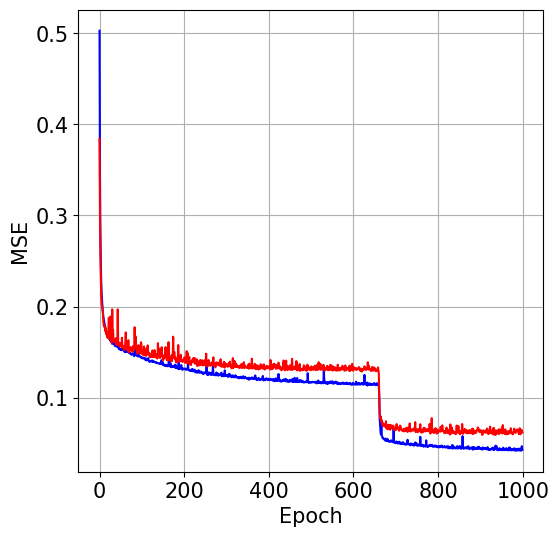

In [25]:
plt.figure(figsize=(6,6))
plt.plot(np.array(history.history['loss']), color='blue', label='Loss')
plt.plot(np.array(history.history['val_loss']), color='red', label='Validation Loss')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.yscale('log')
plt.grid()
plt.show()